In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, auc

df = pd.read_csv("/kaggle/input/final-data/multitude_with_creativity_features.csv")
df.drop('flesch_reading_ease',axis=1,inplace=True)

from sentence_transformers import SentenceTransformer

# Pretrained multilingual model (works across 100+ languages)
embedder = SentenceTransformer("distiluse-base-multilingual-cased-v2")

2025-08-29 03:48:19.473591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756439299.676600      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756439299.743122      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [2]:
df.columns

Index(['text', 'label', 'multi_label', 'split', 'language', 'length', 'source',
       'sentences', 'embeddings', 'unique_word_count', 'type_token_ratio',
       'sentence_count', 'avg_sentence_length', 'semantic_coherence',
       'verbatim_coverage', 'semantic_coverage', 'creativity_score',
       'creativity_index', 'spans'],
      dtype='object')

In [4]:
df.label.value_counts()

label
1    54187
0     6508
Name: count, dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


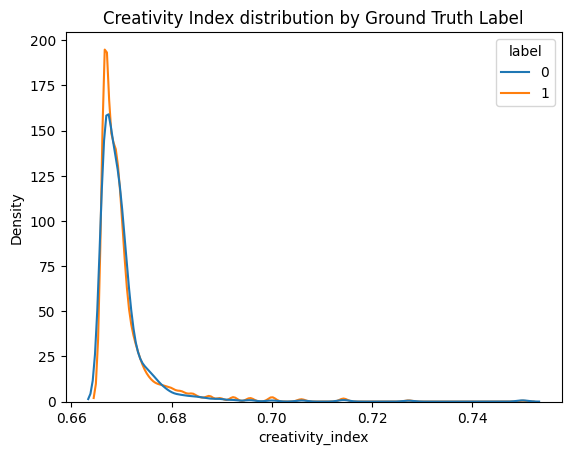

In [4]:
sns.kdeplot(data=df, x="creativity_index", hue="label", common_norm=False)
plt.title("Creativity Index distribution by Ground Truth Label")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


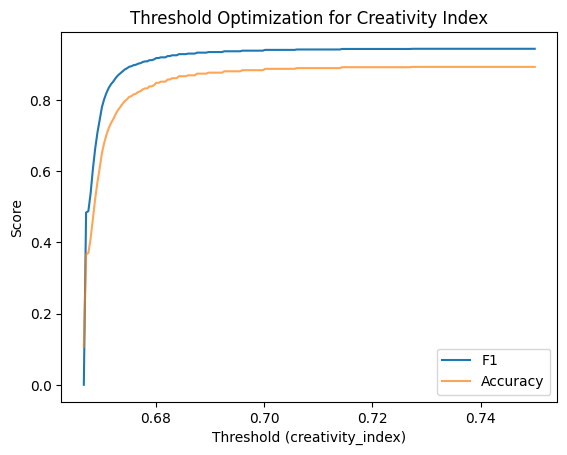

✅ Best threshold: 0.7273869346733669
threshold    0.727387
accuracy     0.892199
f1           0.943017
precision    0.892869
recall       0.999133
Name: 145, dtype: float64


In [2]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def optimize_threshold(df, index_col="creativity_index", label_col="label"):
    """
    Find the best threshold on creativity_index to separate AI (1) vs Human (0).
    Returns best threshold + metrics.
    """
    y_true = df[label_col].values
    thresholds = np.linspace(df[index_col].min(), df[index_col].max(), 200)

    results = []
    for t in thresholds:
        # Predict AI (1) if creativity_index < t (less creative = AI-like)
        y_pred = (df[index_col] < t).astype(int)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        results.append((t, acc, f1, prec, rec))

    # Convert to DataFrame
    metrics_df = pd.DataFrame(results, columns=["threshold", "accuracy", "f1", "precision", "recall"])

    # Pick the best threshold by F1
    best = metrics_df.loc[metrics_df["f1"].idxmax()]

    # Plot F1 vs threshold
    plt.plot(metrics_df["threshold"], metrics_df["f1"], label="F1")
    plt.plot(metrics_df["threshold"], metrics_df["accuracy"], label="Accuracy", alpha=0.7)
    plt.xlabel("Threshold (creativity_index)")
    plt.ylabel("Score")
    plt.title("Threshold Optimization for Creativity Index")
    plt.legend()
    plt.show()

    return best, metrics_df

# Run
best_threshold, metrics_df = optimize_threshold(df)
print("✅ Best threshold:", best_threshold["threshold"])
print(best_threshold)

In [6]:
df['label_creativity'] = df['creativity_index'].apply(lambda x: 0 if x > 0.727 else 1)

In [7]:
df.creativity_index.value_counts()

creativity_index
0.666667    20251
0.673469      486
0.670000      455
0.672727      450
0.669643      442
            ...  
0.667382        1
0.670521        1
0.670374        1
0.668172        1
0.668213        1
Name: count, Length: 225, dtype: int64

In [8]:
import seaborn as sns

# # Quick look at distribution of original label vs creativity-based label
# print(pd.crosstab(df['label'], df['label_creativity'], margins=True))

# # Visualize the distribution with a countplot
# sns.countplot(data=df, x='label', hue='label_creativity')
# plt.title('Distribution of Original Label vs Creativity-Based Label')
# plt.xlabel('Original Label (0=Human, 1=AI)')
# plt.ylabel('Count')
# plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


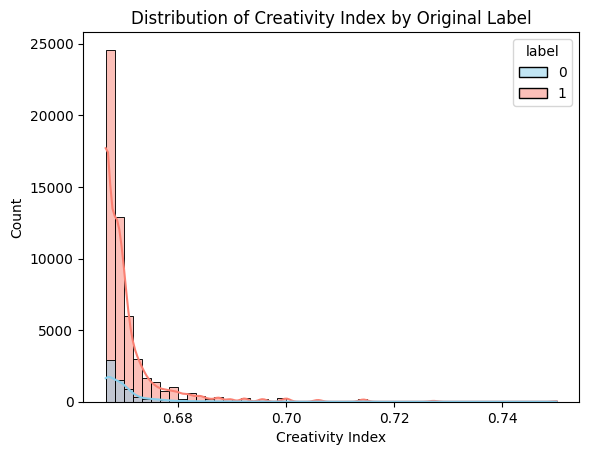

In [9]:

sns.histplot(data=df, x='creativity_index', hue='label', bins=50, kde=True, palette=['skyblue', 'salmon'])
plt.title('Distribution of Creativity Index by Original Label')
plt.xlabel('Creativity Index')
plt.ylabel('Count')
plt.show()

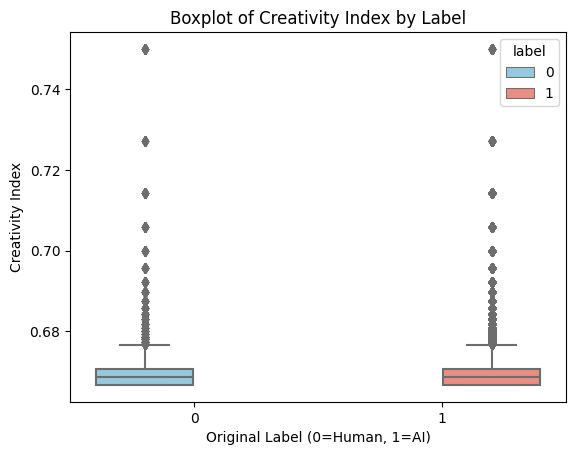

In [14]:
sns.boxplot(data=df, x='label', y='creativity_index', palette=['skyblue', 'salmon'],hue='label')
plt.title('Boxplot of Creativity Index by Label')
plt.xlabel('Original Label (0=Human, 1=AI)')
plt.ylabel('Creativity Index')
plt.show()


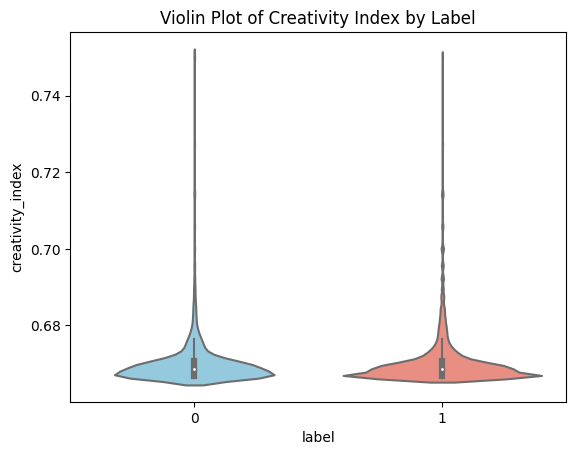

In [15]:
sns.violinplot(data=df, x='label', y='creativity_index', palette=['skyblue', 'salmon'])
plt.title('Violin Plot of Creativity Index by Label')
plt.show()

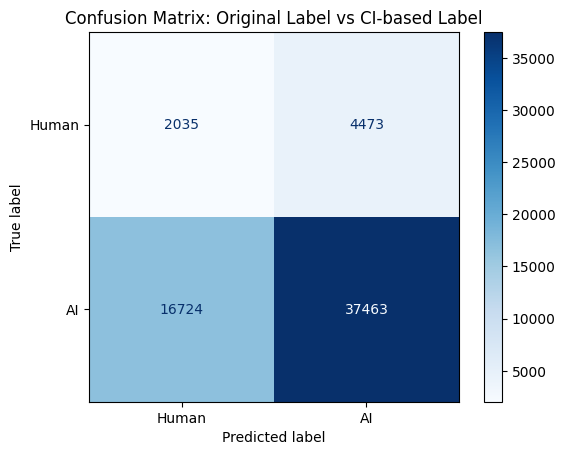

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

threshold = 0.67
df['label_creativity'] = (df['creativity_index'] <= threshold).astype(int)

cm = confusion_matrix(df['label'], df['label_creativity'])
ConfusionMatrixDisplay(cm, display_labels=['Human', 'AI']).plot(cmap='Blues')
plt.title('Confusion Matrix: Original Label vs CI-based Label')
plt.show()

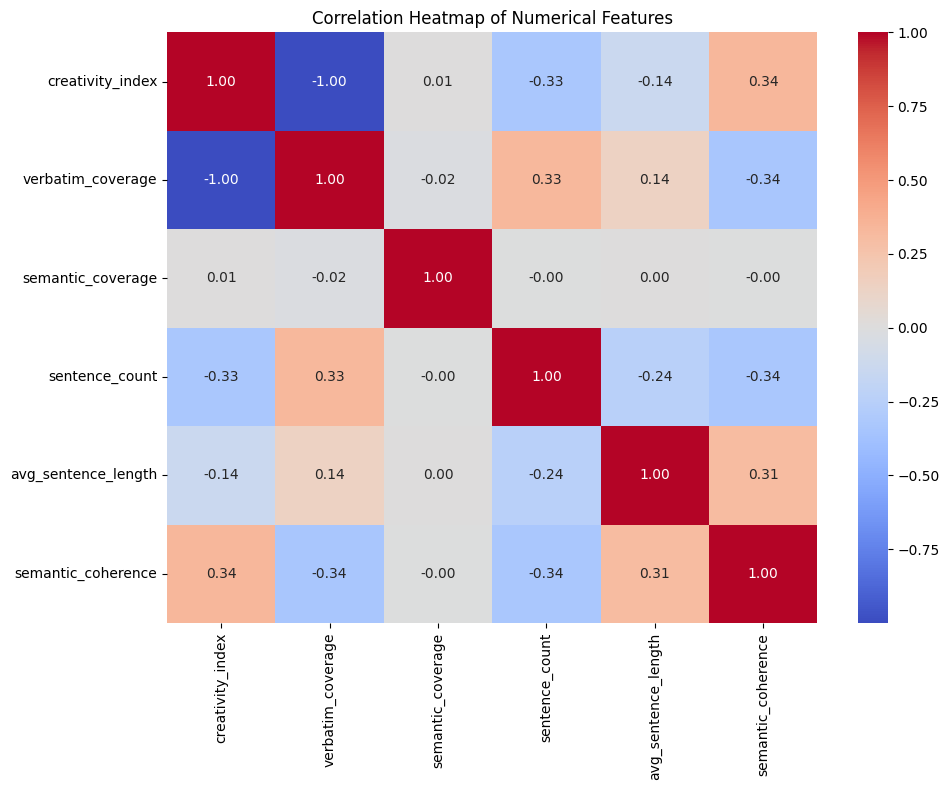

In [10]:

# 5. Correlation heatmap for selected numerical columns
num_cols = ['creativity_index', 'verbatim_coverage', 'semantic_coverage', 'sentence_count', 'avg_sentence_length', 'semantic_coherence']
plt.figure(figsize=(10, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

In [34]:
df.columns

Index(['text', 'label', 'multi_label', 'split', 'language', 'length', 'source',
       'sentences', 'embeddings', 'unique_word_count', 'type_token_ratio',
       'sentence_count', 'avg_sentence_length', 'semantic_coherence',
       'verbatim_coverage', 'semantic_coverage', 'creativity_score',
       'creativity_index', 'spans', 'label_creativity'],
      dtype='object')

In [3]:

# ------------------------
# 1. Define features
# ------------------------

# Without creativity features
features_basic = [
    "unique_word_count",
    "type_token_ratio",
    "sentence_count",
    "avg_sentence_length",
    "semantic_coherence"
]

target = "label"  # 0 for Human, 1 for AI
lang_col = "language"


# With creativity features: automatically pick all except excluded
exclude_cols = ['text', 'label', 'multi_label', 'split', 'source','language',
       'sentences', 'embeddings', 'matched_spans', 'semantic_matched_spans','label_creativity','spans']


features_creativity = [c for c in df.columns if c not in exclude_cols]

# ------------------------
# 2. Train/Test split
# ------------------------
train_df = df[df['split']=='train']
test_df = df[df['split']=='test']


In [4]:
train_df.shape
test_df.shape

langs = test_df[lang_col].unique()

In [5]:


# Add transformer embeddings as features
train_embeddings = embedder.encode(train_df["text"].tolist(), show_progress_bar=True)
test_embeddings  = embedder.encode(test_df["text"].tolist(), show_progress_bar=True)

emb_train_df = pd.DataFrame(train_embeddings, index=train_df.index)
emb_test_df  = pd.DataFrame(test_embeddings, index=test_df.index)



Batches:   0%|          | 0/1400 [00:00<?, ?it/s]

Batches:   0%|          | 0/498 [00:00<?, ?it/s]

In [6]:
test_embeddings.shape

(15909, 512)

In [7]:


train_langs = train_df[lang_col].unique()
test_inlang_df = test_df[test_df[lang_col].isin(train_langs)]
test_zeroshot_df = test_df[~test_df[lang_col].isin(train_langs)]

X_train_basic =  train_df[features_basic]
# X_train_creativity = train_df[features_creativity]
# y_train = train_df[target]

X_test_basic = test_df[features_basic]
# X_test_creativity = , test_df[features_creativity]
# y_test = test_df[target]


# Combine creativity + embeddings
X_train_creativity = pd.concat([train_df[features_creativity], emb_train_df], axis=1)
X_test_creativity  = pd.concat([test_df[features_creativity], emb_test_df], axis=1)

y_train = train_df[target]
y_test  = test_df[target]


print("Train:", X_train_creativity.shape, y_train.shape)
print("Test:", X_test_creativity.shape, y_test.shape)

# Compute class weight for imbalance
human_count = (y_train == 0).sum()
ai_count = (y_train == 1).sum()
scale_pos_weight = human_count / ai_count






Train: (44786, 522) (44786,)
Test: (15909, 522) (15909,)


In [21]:
X_train_creativity.columns


Index([             'length',   'unique_word_count',    'type_token_ratio',
            'sentence_count', 'avg_sentence_length',  'semantic_coherence',
         'verbatim_coverage',   'semantic_coverage',    'creativity_score',
          'creativity_index',
       ...
                         502,                   503,                   504,
                         505,                   506,                   507,
                         508,                   509,                   510,
                         511],
      dtype='object', length=522)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import optuna
X_train_creativity.columns = X_train_creativity.columns.astype(str)
X_test_creativity.columns = X_test_creativity.columns.astype(str)

# Now scale
scaler = StandardScaler()
X_train_creativity_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_creativity),
    index=X_train_creativity.index,
    columns=X_train_creativity.columns  # already all strings
)
X_test_creativity_scaled = pd.DataFrame(
    scaler.transform(X_test_creativity),
    index=X_test_creativity.index,
    columns=X_test_creativity.columns
)
# # (Optional) reduce embeddings dimensionality to 100
# pca = PCA(n_components=100, random_state=42)
# X_train_creativity_pca = pd.DataFrame(
#     pca.fit_transform(X_train_creativity_scaled),
#     index=X_train_creativity.index
# )
# X_test_creativity_pca = pd.DataFrame(
#     pca.transform(X_test_creativity_scaled),
#     index=X_test_creativity.index
# )




=== Macro-F1 Comparison per Language ===
  Language  Macro-F1 (Basic)  Macro-F1 (Creativity)      Δ F1
0       de          0.469112               0.593515  0.124403
1       en          0.601230               0.722371  0.121141
2       nl          0.623480               0.558780 -0.064700
3       ca          0.600486               0.588116 -0.012370
4       ru          0.549971               0.698526  0.148554
5       es          0.661870               0.707061  0.045191


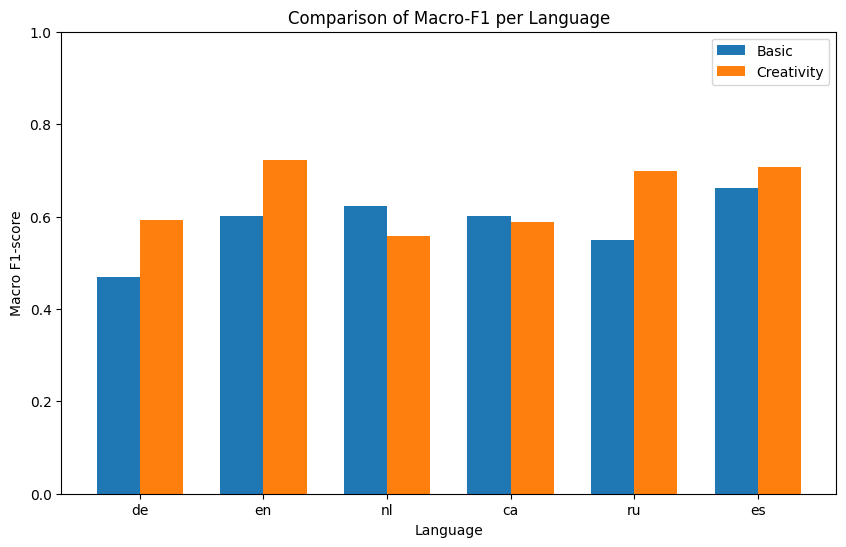

In [9]:

# ------------------------
# 3. Train models
# ------------------------
model_basic = XGBClassifier(
    n_estimators=600, max_depth=6, learning_rate=0.07, subsample=0.8,
    colsample_bytree=0.8, eval_metric='logloss', use_label_encoder=False,
    scale_pos_weight=scale_pos_weight
)
model_basic.fit(X_train_basic, y_train)

model_creativity = XGBClassifier(
    objective='binary:logistic', eval_metric='aucpr', use_label_encoder=False,
    scale_pos_weight=scale_pos_weight, n_estimators=400, max_depth=6, learning_rate=0.1,
    random_state=42
)
model_creativity.fit(X_train_creativity_scaled, y_train)

# ------------------------
# 4. Evaluation functions
# ------------------------
def eval_model(model, X, y_true, features):
    y_proba = model.predict_proba(X)[:,1]
    y_pred = (y_proba >= 0.5).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True, target_names=["Human(0)", "AI(1)"])
    cm = confusion_matrix(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return report, cm, macro_f1

# ------------------------
# 5. Evaluate per language
# ------------------------
results_basic = {}
results_creativity = {}

langs = test_df[lang_col].unique()

for lang in langs:
    mask = test_df[lang_col]==lang

    # Basic
    report, cm, macro_f1 = eval_model(model_basic, X_test_basic.loc[mask], y_test.loc[mask], features_basic)
    results_basic[lang] = {"report": report, "confusion_matrix": cm, "macro_f1": macro_f1}

    # Creativity
    report, cm, macro_f1 = eval_model(model_creativity, X_test_creativity_scaled.loc[mask], y_test.loc[mask], features_creativity)
    results_creativity[lang] = {"report": report, "confusion_matrix": cm, "macro_f1": macro_f1}

# ------------------------
# 6. Comparison table
# ------------------------
comparison_df = pd.DataFrame({
    "Language": langs,
    "Macro-F1 (Basic)": [results_basic[lang]['macro_f1'] for lang in langs],
    "Macro-F1 (Creativity)": [results_creativity[lang]['macro_f1'] for lang in langs],
})
comparison_df["Δ F1"] = comparison_df["Macro-F1 (Creativity)"] - comparison_df["Macro-F1 (Basic)"]
print("\n=== Macro-F1 Comparison per Language ===")
print(comparison_df)

# ------------------------
# 7. F1-score bar chart
# ------------------------
plt.figure(figsize=(10,6))
x = np.arange(len(langs))
width = 0.35
plt.bar(x - width/2, comparison_df["Macro-F1 (Basic)"], width, label="Basic")
plt.bar(x + width/2, comparison_df["Macro-F1 (Creativity)"], width, label="Creativity")
plt.xticks(x, langs)
plt.ylabel("Macro F1-score")
plt.xlabel("Language")
plt.title("Comparison of Macro-F1 per Language")
plt.ylim(0,1)
plt.legend()
plt.show()

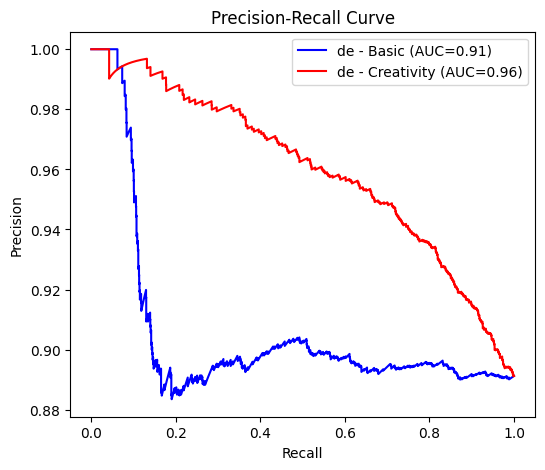

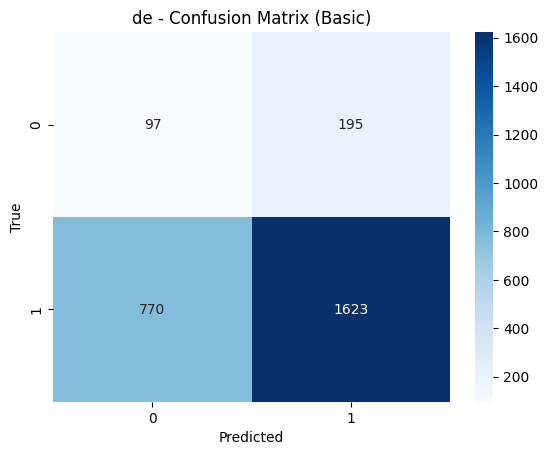

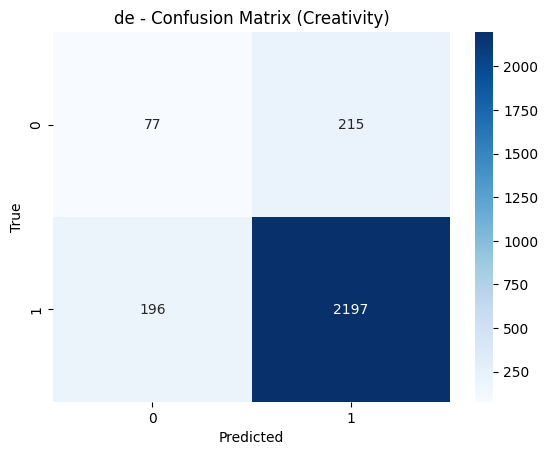

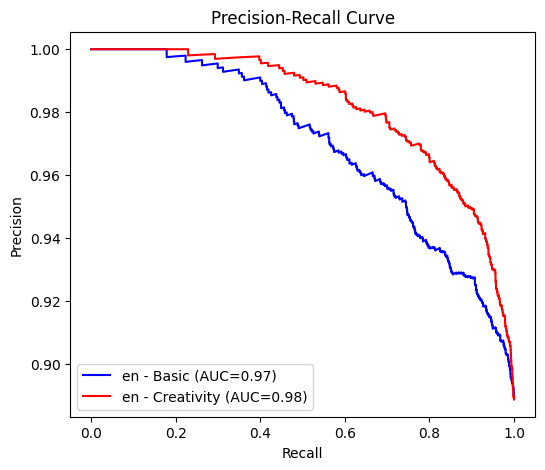

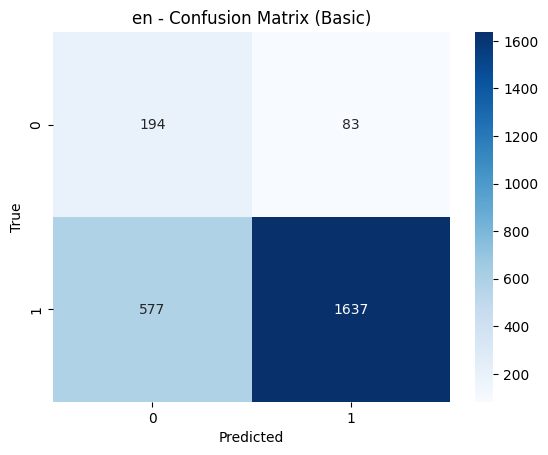

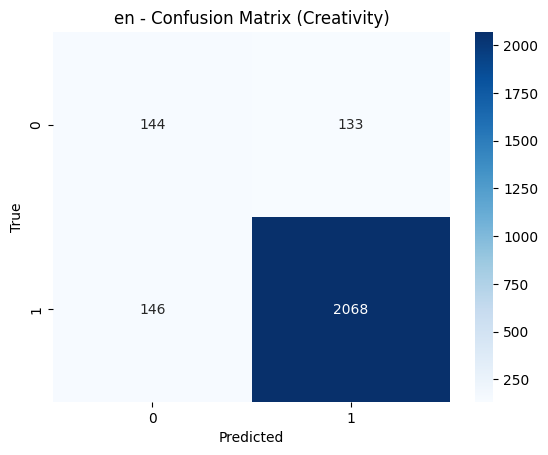

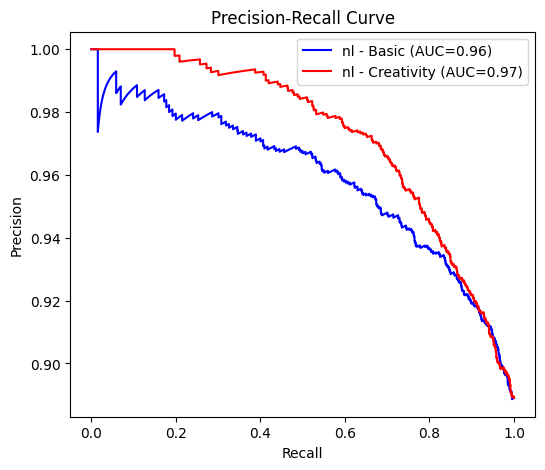

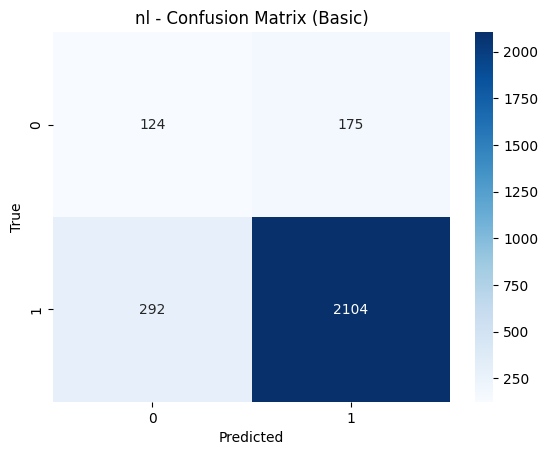

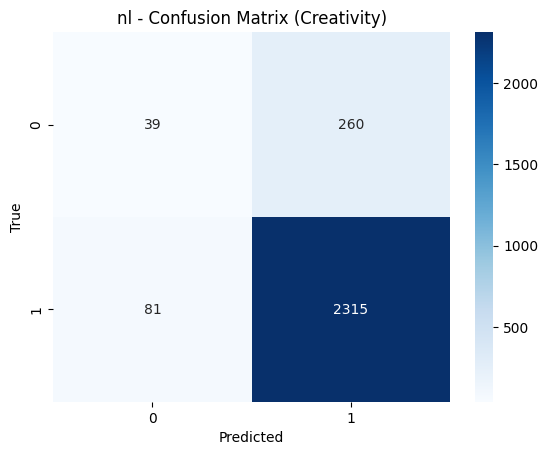

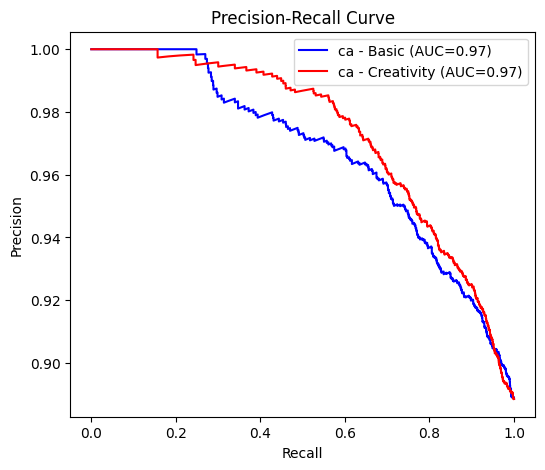

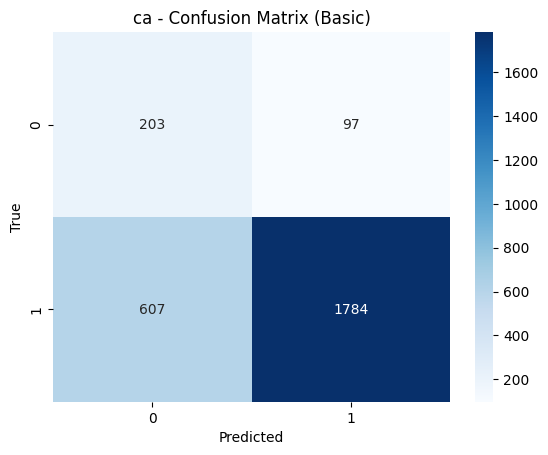

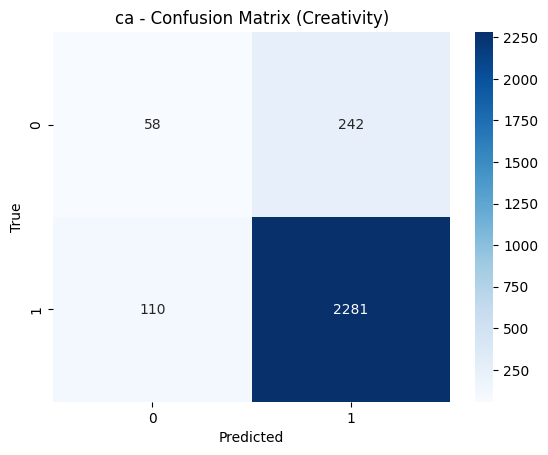

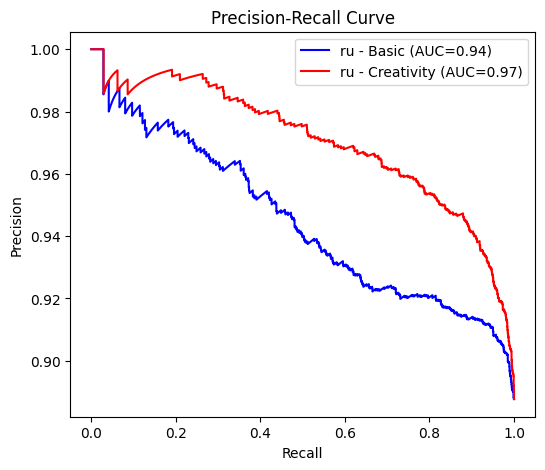

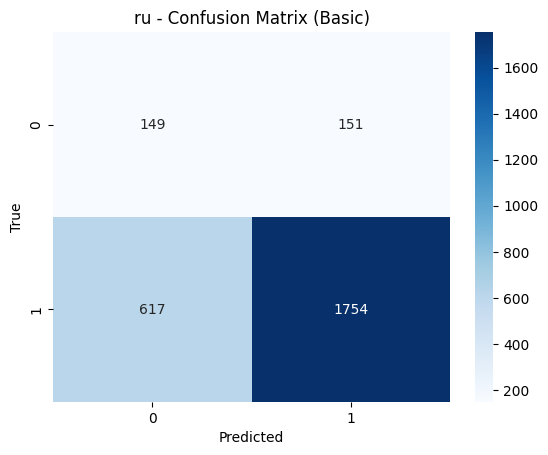

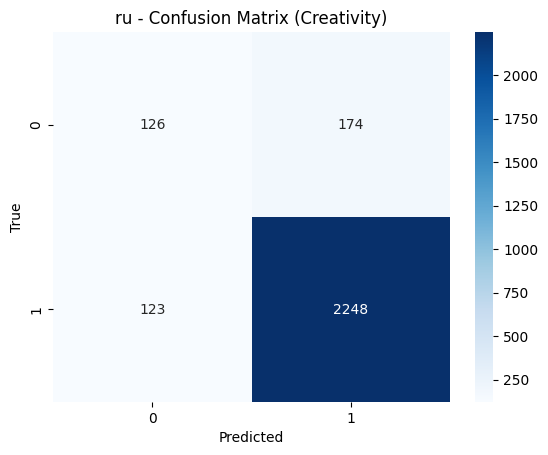

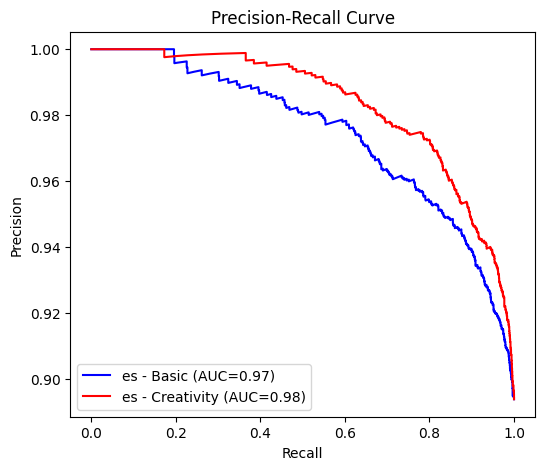

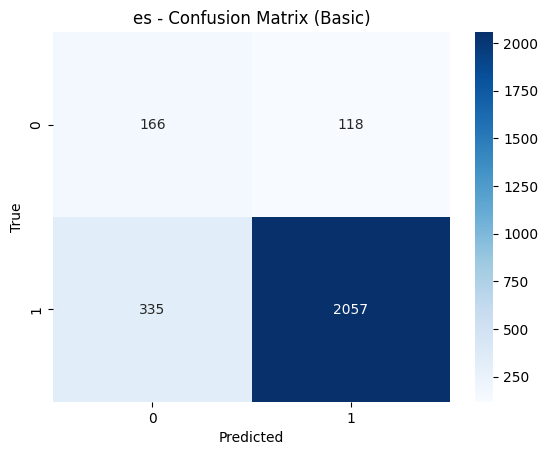

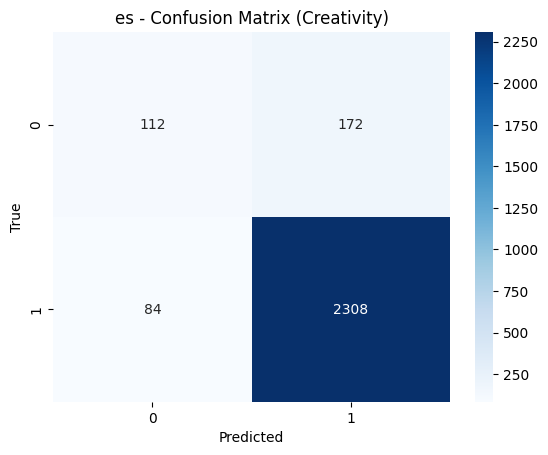

In [10]:
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(y_true, y_proba, label="", color=None):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{label} (AUC={pr_auc:.2f})", color=color)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

def plot_conf_matrix(cm, labels=[0,1], title="Confusion Matrix"):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# ------------------------
# 9. Plot PR & Confusion matrices per language
# ------------------------
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']  # for multiple languages
for idx, lang in enumerate(langs):
    mask = test_df[lang_col]==lang

    # --- Predictions ---
    y_true = y_test.loc[mask]

    # Basic model
    y_proba_basic = model_basic.predict_proba(X_test_basic.loc[mask])[:,1]
    y_pred_basic = (y_proba_basic >= 0.5).astype(int)
    
    # Creativity model
    y_proba_crea = model_creativity.predict_proba(X_test_creativity_scaled.loc[mask])[:,1]
    y_pred_crea = (y_proba_crea >= 0.5).astype(int)
    
    # --- PR Curve ---
    plt.figure(figsize=(6,5))
    plot_pr_curve(y_true, y_proba_basic, label=f"{lang} - Basic", color='blue')
    plot_pr_curve(y_true, y_proba_crea, label=f"{lang} - Creativity", color='red')
    plt.show()
    
    # --- Confusion Matrices ---
    cm_basic = confusion_matrix(y_true, y_pred_basic)
    cm_crea = confusion_matrix(y_true, y_pred_crea)
    
    plot_conf_matrix(cm_basic, title=f"{lang} - Confusion Matrix (Basic)")
    plot_conf_matrix(cm_crea, title=f"{lang} - Confusion Matrix (Creativity)")

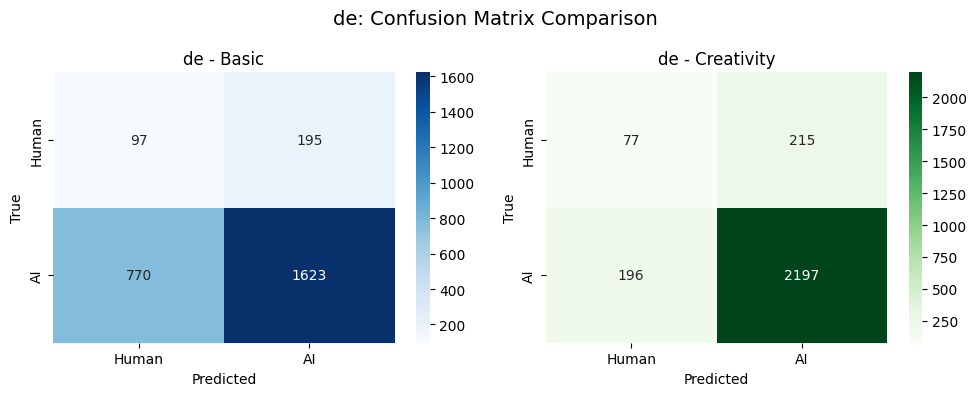

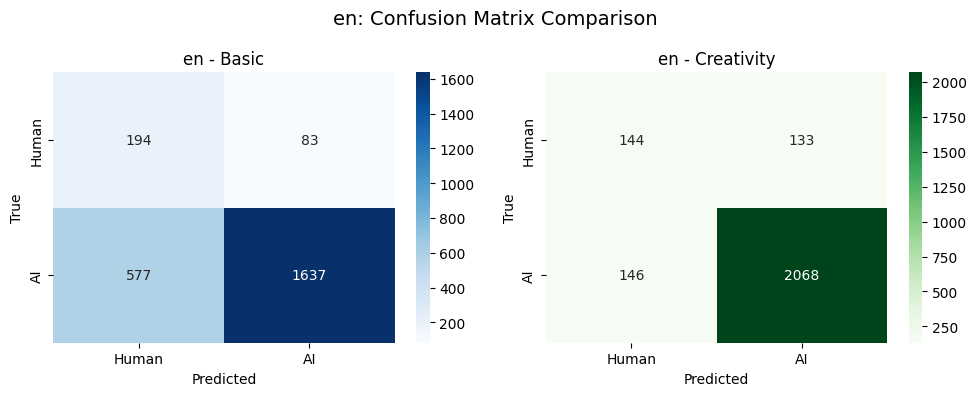

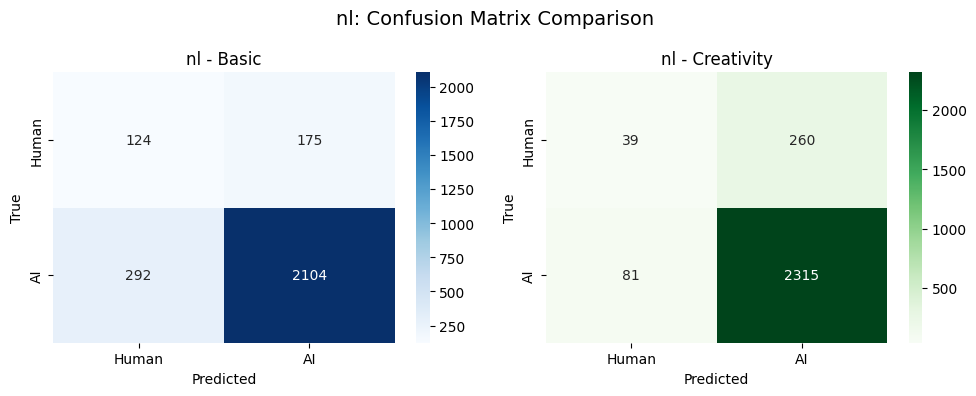

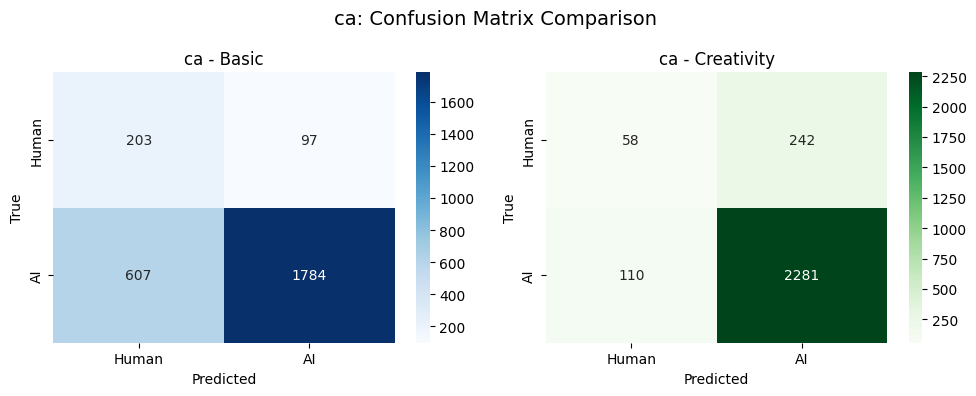

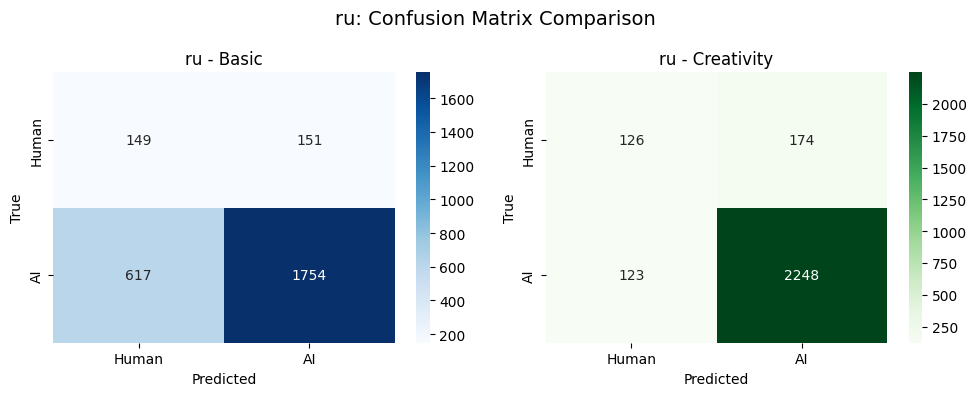

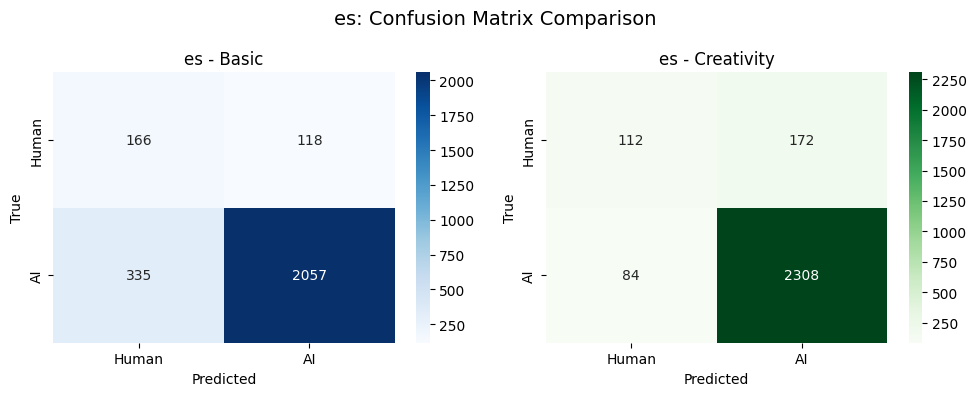

In [11]:
def plot_cm(ax, y_true, y_pred, model_name, cmap):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap,
                xticklabels=["Human","AI"], yticklabels=["Human","AI"], ax=ax)
    ax.set_title(f"{model_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# ------------------------
# Side-by-side confusion matrices per language
# ------------------------
for lang in langs:
    mask = test_df[lang_col] == lang
    y_true = y_test.loc[mask]

    # Predictions
    y_proba_basic = model_basic.predict_proba(X_test_basic.loc[mask])[:,1]
    y_pred_basic = (y_proba_basic >= 0.5).astype(int)

    y_proba_crea = model_creativity.predict_proba(X_test_creativity_scaled.loc[mask])[:,1]
    y_pred_crea = (y_proba_crea >= 0.5).astype(int)

    # Plot 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plot_cm(axes[0], y_true, y_pred_basic, f"{lang} - Basic", "Blues")
    plot_cm(axes[1], y_true, y_pred_crea, f"{lang} - Creativity", "Greens")

    plt.suptitle(f"{lang}: Confusion Matrix Comparison", fontsize=14)
    plt.tight_layout()
    plt.show()

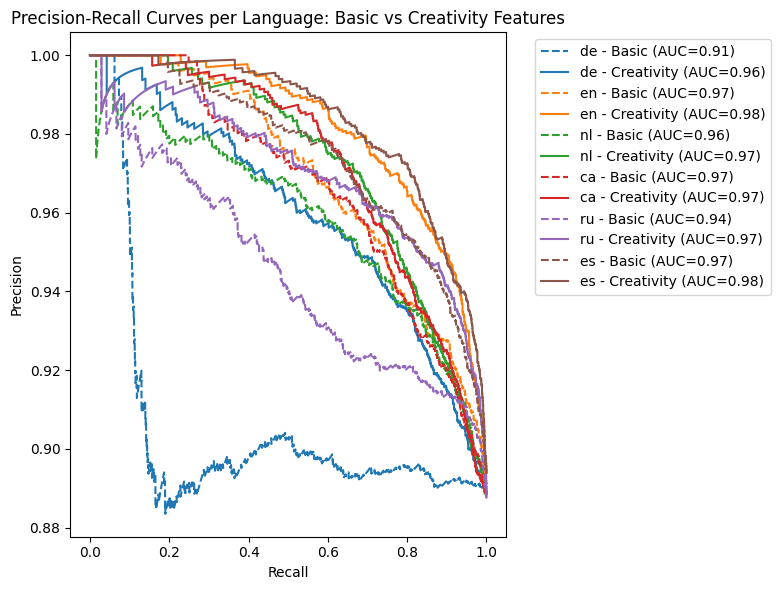

In [12]:
# ------------------------
plt.figure(figsize=(8,6))

colors = sns.color_palette("tab10", len(test_df[lang_col].unique()))
langs = test_df[lang_col].unique()

for idx, lang in enumerate(langs):
    mask = test_df[lang_col] == lang
    y_true = test_df.loc[mask, target]

    # Basic model
    y_proba_basic = model_basic.predict_proba(X_test_basic.loc[mask])[:,1]
    precision, recall, _ = precision_recall_curve(y_true, y_proba_basic)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{lang} - Basic (AUC={pr_auc:.2f})", color=colors[idx], linestyle='--')

    # Creativity model
    y_proba_crea = model_creativity.predict_proba(X_test_creativity_scaled.loc[mask])[:,1]
    precision, recall, _ = precision_recall_curve(y_true, y_proba_crea)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{lang} - Creativity (AUC={pr_auc:.2f})", color=colors[idx], linestyle='-')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves per Language: Basic vs Creativity Features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # legend outside plot
plt.tight_layout()
plt.show()

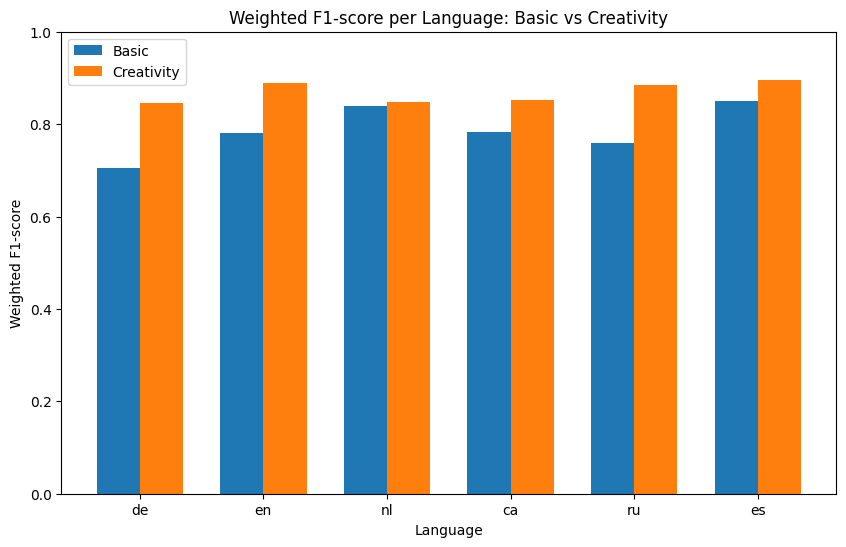

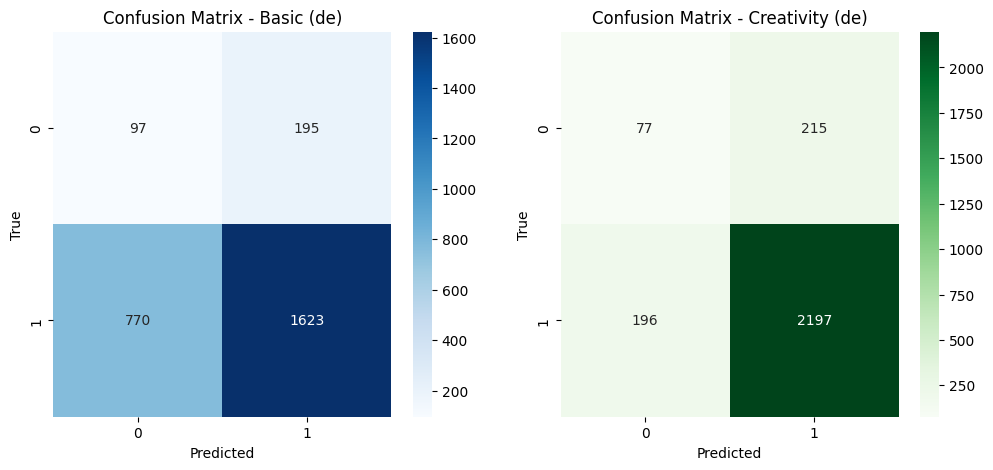

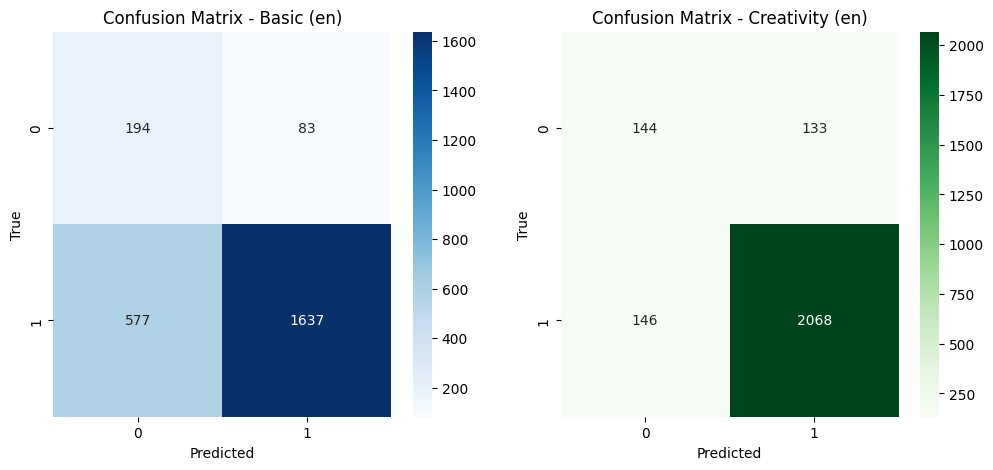

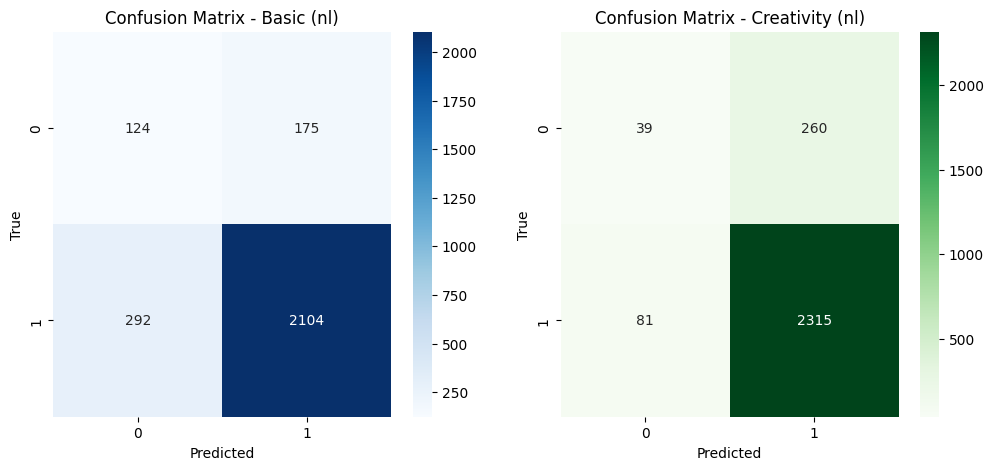

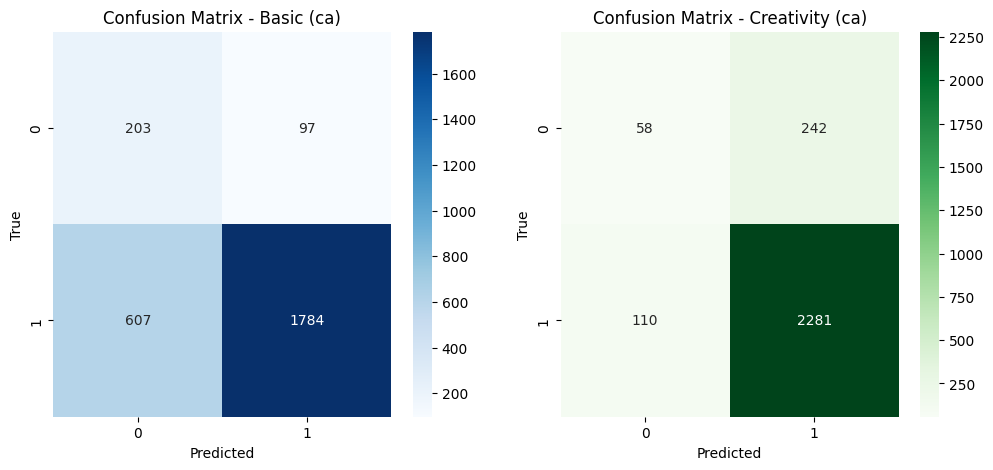

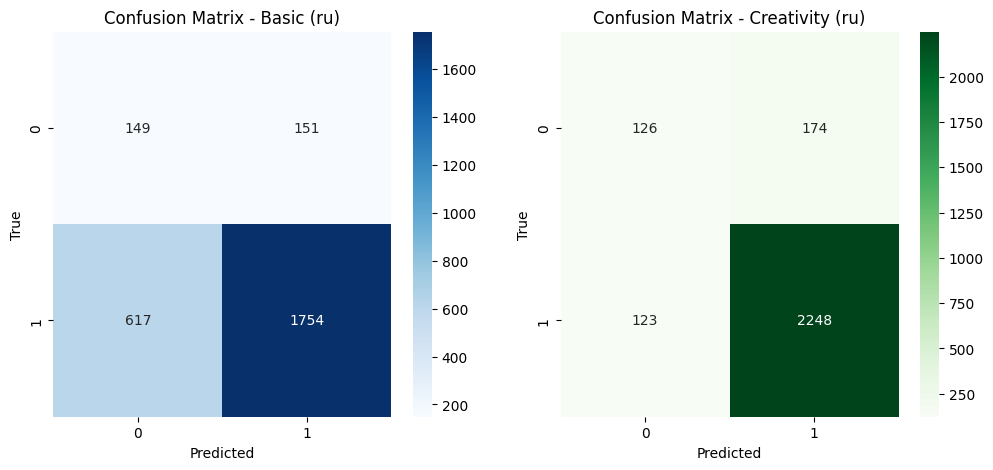

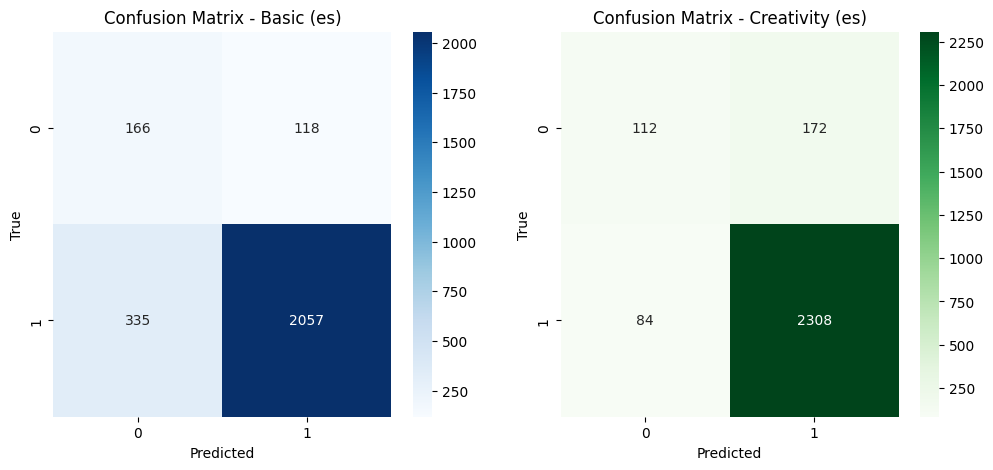

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# =========================
# 1. F1-score bar plot per language (weighted F1)
# =========================
langs = list(results_basic.keys())
f1_basic = [results_basic[lang]['report']['weighted avg']['f1-score'] for lang in langs]
f1_creativity = [results_creativity[lang]['report']['weighted avg']['f1-score'] for lang in langs]

x = np.arange(len(langs))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, f1_basic, width, label='Basic')
rects2 = ax.bar(x + width/2, f1_creativity, width, label='Creativity')

ax.set_ylabel('Weighted F1-score')
ax.set_xlabel('Language')
ax.set_title('Weighted F1-score per Language: Basic vs Creativity')
ax.set_xticks(x)
ax.set_xticklabels(langs)
ax.set_ylim(0,1)
ax.legend()
plt.show()

# =========================
# 2. Confusion matrix side-by-side
# =========================
def plot_cm_side_by_side(lang, results_basic, results_creativity):
    cm_basic = results_basic[lang]['confusion_matrix']
    cm_creativity = results_creativity[lang]['confusion_matrix']

    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    
    sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - Basic ({lang})')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    
    sns.heatmap(cm_creativity, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix - Creativity ({lang})')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    
    plt.show()

# Example: plot for English'
for l in langs:
    
    plot_cm_side_by_side(l, results_basic, results_creativity)

# You can loop over all languages if needed:
# for lang in langs:
#     plot_cm_side_by_side(lang, results_basic, results_creativity)


In [14]:
def plot_all_metrics_per_language(model, X_test, y_test, languages, train_langs=None):
    """
    Plots PR curve, Confusion Matrix, and ROC curve per language.
    
    Parameters:
        model : trained classifier with predict_proba
        X_test : DataFrame of test features (creativity+embeddings or basic)
        y_test : Series of ground-truth labels
        languages : Series of language labels for each row in test
        train_langs : list of languages seen in training (optional, to mark zero-shot)
    """
    for lang in languages.unique():
        mask = languages == lang
        X_lang, y_true = X_test.loc[mask], y_test.loc[mask]
        
        y_scores = model.predict_proba(X_lang)[:, 1]
        y_pred   = (y_scores >= 0.5).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        zero_shot_tag = " (Zero-shot)" if train_langs is not None and lang not in train_langs else ""
        lang_name = f"{lang}{zero_shot_tag}"

        print(f"\n=== {lang_name} ===")
        print(classification_report(y_true, y_pred, target_names=["Human(0)", "AI(1)"]))
        print("Confusion Matrix:\n", cm)

        # --- Precision-Recall curve ---
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        plt.figure(figsize=(5,4))
        plt.plot(recall, precision, label=f"AP={auc(recall, precision):.2f}")
        plt.title(f"Precision-Recall Curve - {lang_name}")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
        plt.show()

        # --- Confusion Matrix ---
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=["Human(0)", "AI(1)"], 
                    yticklabels=["Human(0)", "AI(1)"])
        plt.title(f"Confusion Matrix - {lang_name}")
        plt.ylabel("True"); plt.xlabel("Predicted")
        plt.show()

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC={auc(fpr, tpr):.2f}")
        plt.plot([0,1],[0,1],'--',color="gray")
        plt.title(f"ROC Curve - {lang_name}")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()
        plt.show()


=== de (Zero-shot) ===
              precision    recall  f1-score   support

    Human(0)       0.00      0.00      0.00       292
       AI(1)       0.89      1.00      0.94      2393

    accuracy                           0.89      2685
   macro avg       0.45      0.50      0.47      2685
weighted avg       0.79      0.89      0.84      2685

Confusion Matrix:
 [[   0  292]
 [   0 2393]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


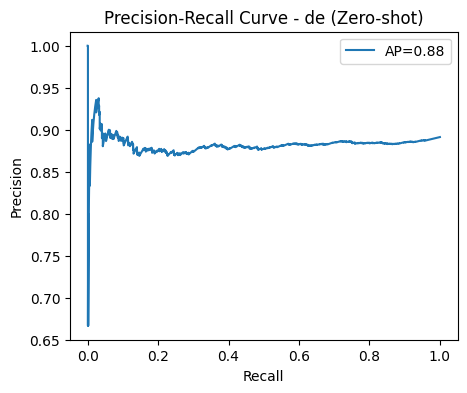

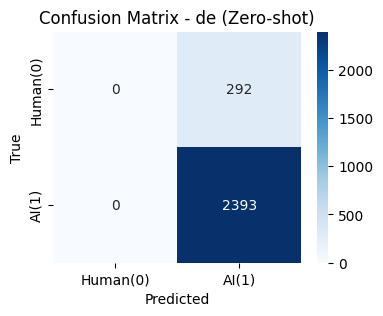

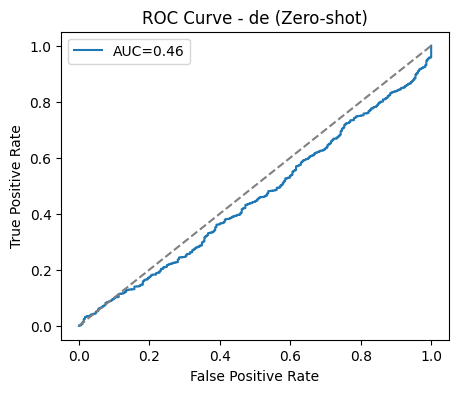


=== en ===
              precision    recall  f1-score   support

    Human(0)       0.00      0.00      0.00       277
       AI(1)       0.89      1.00      0.94      2214

    accuracy                           0.89      2491
   macro avg       0.44      0.50      0.47      2491
weighted avg       0.79      0.89      0.84      2491

Confusion Matrix:
 [[   0  277]
 [   0 2214]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


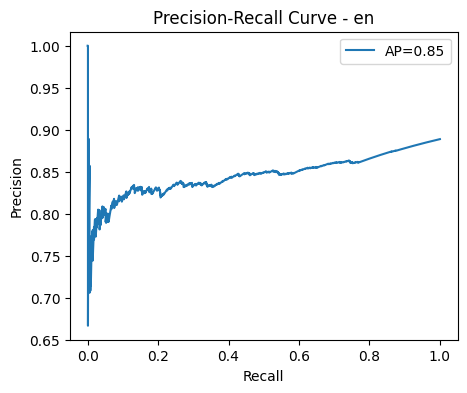

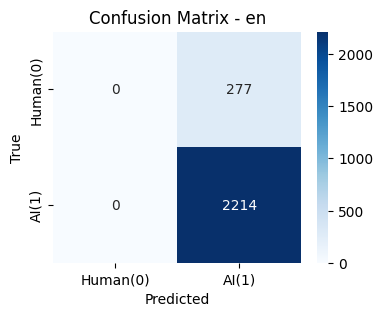

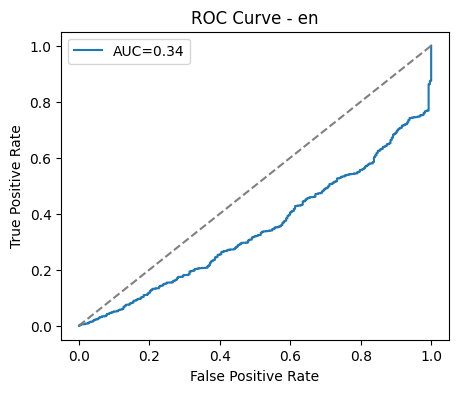


=== nl (Zero-shot) ===
              precision    recall  f1-score   support

    Human(0)       0.00      0.00      0.00       299
       AI(1)       0.89      1.00      0.94      2396

    accuracy                           0.89      2695
   macro avg       0.44      0.50      0.47      2695
weighted avg       0.79      0.89      0.84      2695

Confusion Matrix:
 [[   0  299]
 [   0 2396]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


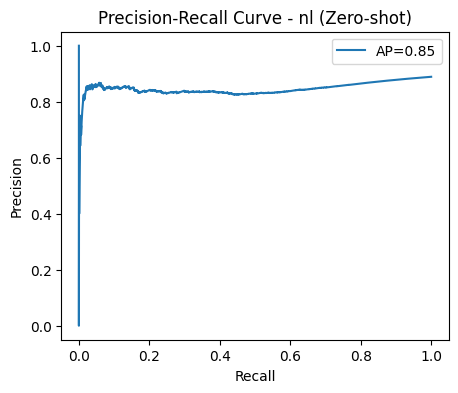

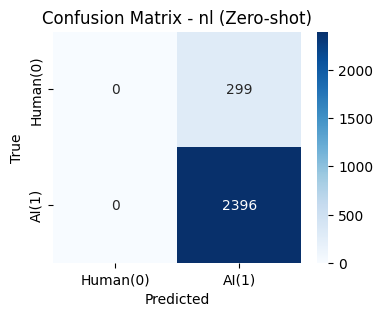

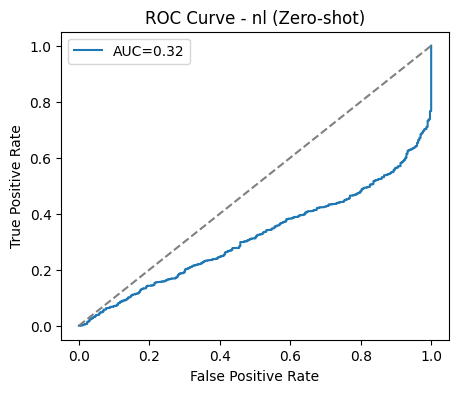


=== ca (Zero-shot) ===
              precision    recall  f1-score   support

    Human(0)       0.00      0.00      0.00       300
       AI(1)       0.89      1.00      0.94      2391

    accuracy                           0.89      2691
   macro avg       0.44      0.50      0.47      2691
weighted avg       0.79      0.89      0.84      2691

Confusion Matrix:
 [[   0  300]
 [   0 2391]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


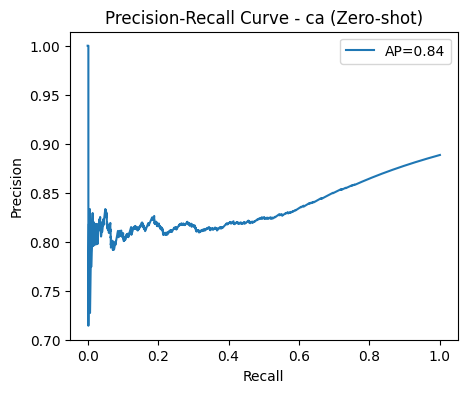

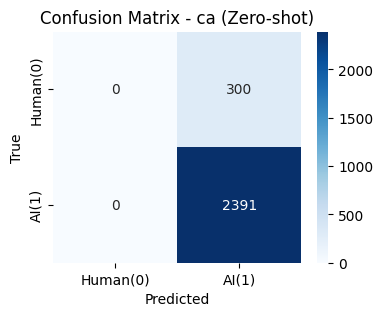

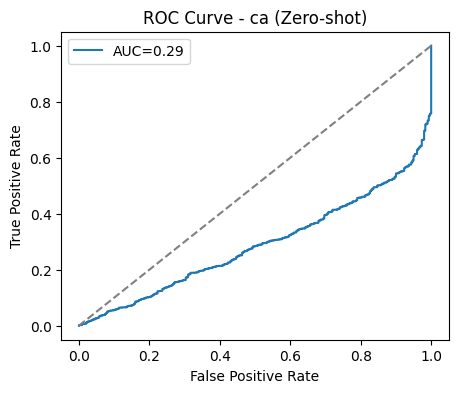


=== ru ===
              precision    recall  f1-score   support

    Human(0)       0.00      0.00      0.00       300
       AI(1)       0.89      1.00      0.94      2371

    accuracy                           0.89      2671
   macro avg       0.44      0.50      0.47      2671
weighted avg       0.79      0.89      0.83      2671

Confusion Matrix:
 [[   0  300]
 [   0 2371]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


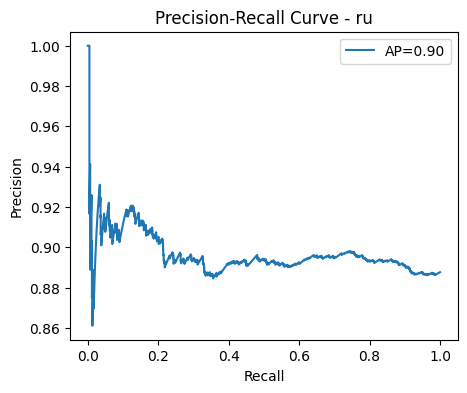

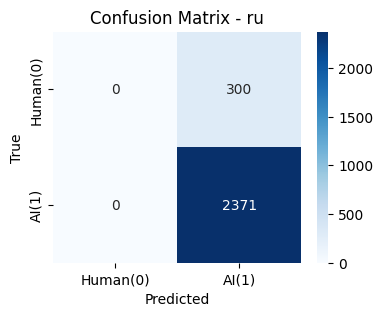

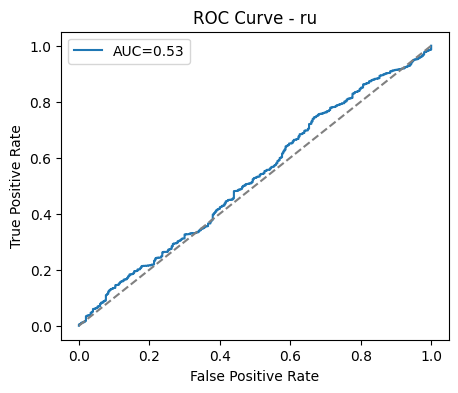


=== es ===
              precision    recall  f1-score   support

    Human(0)       0.00      0.00      0.00       284
       AI(1)       0.89      1.00      0.94      2392

    accuracy                           0.89      2676
   macro avg       0.45      0.50      0.47      2676
weighted avg       0.80      0.89      0.84      2676

Confusion Matrix:
 [[   0  284]
 [   0 2392]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


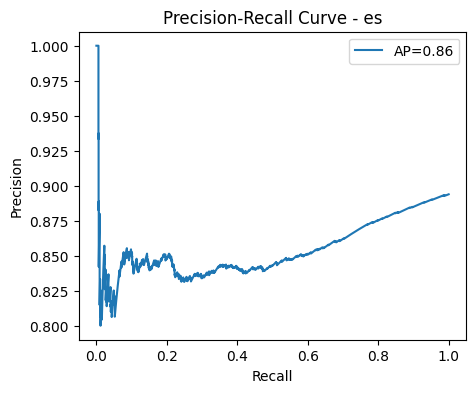

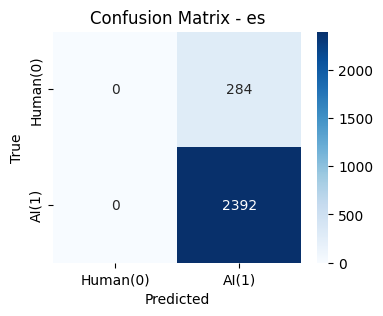

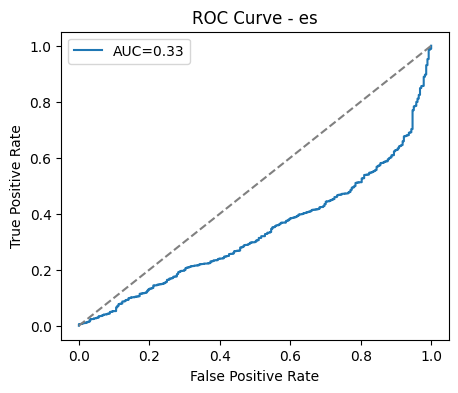

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

plot_all_metrics_per_language(
    model_creativity,
    X_test_creativity,
    y_test,
    test_df["language"],
    train_langs=train_langs
)

## Hyperparameter Tuning

In [19]:

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "scale_pos_weight": scale_pos_weight,
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "use_label_encoder": False,
        "random_state": 42,
         "tree_method": "hist",        # <-- GPU
        "device": "cuda"      # <-- GPU
    }
    model = XGBClassifier(**params)
    model.fit(X_train_creativity_scaled, y_train)
    preds = model.predict(X_test_creativity_scaled)
    return f1_score(y_test, preds, average="macro")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best XGB Params:", best_params)

# Train tuned XGB
model_xgb_tuned = XGBClassifier(**best_params )
model_xgb_tuned.fit(X_train_creativity_scaled, y_train)

[I 2025-08-28 17:41:50,915] A new study created in memory with name: no-name-e9dbd0e7-6bdb-4b9b-af3c-16b7e9fdd8b6
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:42:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2025-08-28 17:42:01,608] Trial 0 finished with value: 0.6089159151874083 and parameters: {'n_estimators': 707, 'max_depth': 10, 'learning_rate': 0.27246932146228037, 'subsample': 0.9477535908188661, 'colsample_bytree': 0.8903228680004205}. Best is trial 0 with value: 0.6089159151874083.
[I 2025-08-28 17:42:05,868] Trial 1 fin

Best XGB Params: {'n_estimators': 767, 'max_depth': 5, 'learning_rate': 0.05993575889125124, 'subsample': 0.9139609290005657, 'colsample_bytree': 0.9590446568469159}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9590446568469159, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05993575889125124,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=767, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
# # ------------------------
# # 3. Ensemble model
# # ------------------------

# log_reg = LogisticRegression(max_iter=1000, class_weight="balanced",solver="saga",n_jobs=-1)
# rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, class_weight="balanced",n_jobs=-1)

# ensemble = VotingClassifier(
#     estimators=[
#         ("xgb", model_xgb_tuned),
#         ("logreg", log_reg),
#         ("rf", rf)
#     ],
#     voting="soft"  # soft voting uses predicted probabilities
# )
# ensemble.fit(X_train_creativity_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9590446568469159,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=No...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=767, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('logreg',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, n_jobs=-1,
                                                 solver='saga')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=8,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 voting='soft')

In [24]:
# # ------------------------
# # 3. Compute optimal threshold for F1
# # ------------------------
# y_proba = ensemble.predict_proba(X_test_creativity_scaled)[:,1]

# def optimal_threshold(y_true, y_proba):
#     thresholds = np.linspace(0.1, 0.9, 100)
#     f1_scores = [f1_score(y_true, (y_proba >= t).astype(int)) for t in thresholds]
#     best_idx = np.argmax(f1_scores)
#     return thresholds[best_idx], f1_scores[best_idx]

# best_thresh, best_f1 = optimal_threshold(y_test, y_proba)
# print(f"Best threshold: {best_thresh:.2f}, F1: {best_f1:.3f}")

Best threshold: 0.38, F1: 0.944


In [1]:
# # ------------------------
# # 4. Predictions using optimal threshold
# # ------------------------
# y_pred_opt = (y_proba >= best_thresh).astype(int)

# # ------------------------
# # 5. Evaluation
# # ------------------------
# report_ens = classification_report(y_test, y_pred_opt, target_names=["Human(0)", "AI(1)"])
# cm_ens = confusion_matrix(y_test, y_pred_opt)
# macro_f1_ens = f1_score(y_test, y_pred_opt, average="macro")

# print("\n=== Optimized Ensemble Results ===")
# print("Macro F1:", macro_f1_ens)
# print("Confusion Matrix:\n", cm_ens)
# print("\nClassification Report:\n", report_ens)

In [16]:
langs = test_df['language'].unique()
results_per_lang = {}

for lang in langs:
    mask = test_df['language'] == lang
    y_true_lang = y_test.loc[mask]
    X_lang = X_test_creativity_scaled.loc[mask]
    y_proba_lang = ensemble.predict_proba(X_lang)[:,1]
    y_pred_lang = (y_proba_lang >= best_thresh).astype(int)
    report = classification_report(y_true_lang, y_pred_lang, output_dict=True, target_names=["Human(0)", "AI(1)"])
    cm = confusion_matrix(y_true_lang, y_pred_lang)
    macro_f1 = f1_score(y_true_lang, y_pred_lang, average='macro')
    results_per_lang[lang] = {"report": report, "confusion_matrix": cm, "macro_f1": macro_f1}

# Macro-F1 comparison table
comparison_df = pd.DataFrame({
    "Language": langs,
    "Macro-F1": [results_per_lang[lang]['macro_f1'] for lang in langs]
})
print("\n=== Macro-F1 per Language ===")
print(comparison_df)

NameError: name 'ensemble' is not defined

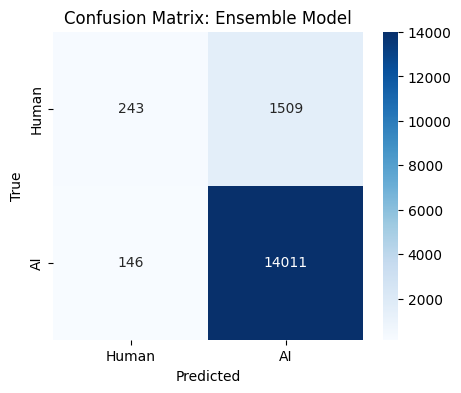

In [27]:

# 5a. Confusion matrix overall
plt.figure(figsize=(5,4))
sns.heatmap(cm_ens, annot=True, fmt="d", cmap="Blues", xticklabels=["Human","AI"], yticklabels=["Human","AI"])
plt.title("Confusion Matrix: Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

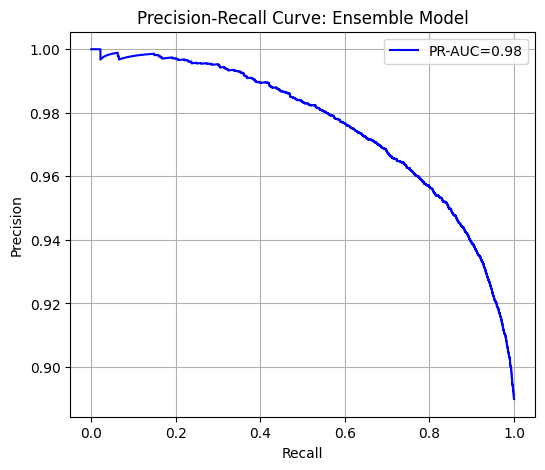

In [28]:

# 5c. Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec, prec)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, color='blue', label=f'PR-AUC={pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Ensemble Model")
plt.legend()
plt.grid(True)
plt.show()

In [98]:


# plot_precision_recall_curve(X_test_inlang, y_test_inlang, model, best_thresh_inlang, "In-Language Test Precision-Recall Curve")

# plot_precision_recall_curve(X_test_zeroshot, y_test_zeroshot, model, best_thresh_zeroshot, "Zero-Shot Test Precision-Recall Curve")

In [78]:

# # 12. Feature Importances

# importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
# print("\nFeature Importances:\n", importances)

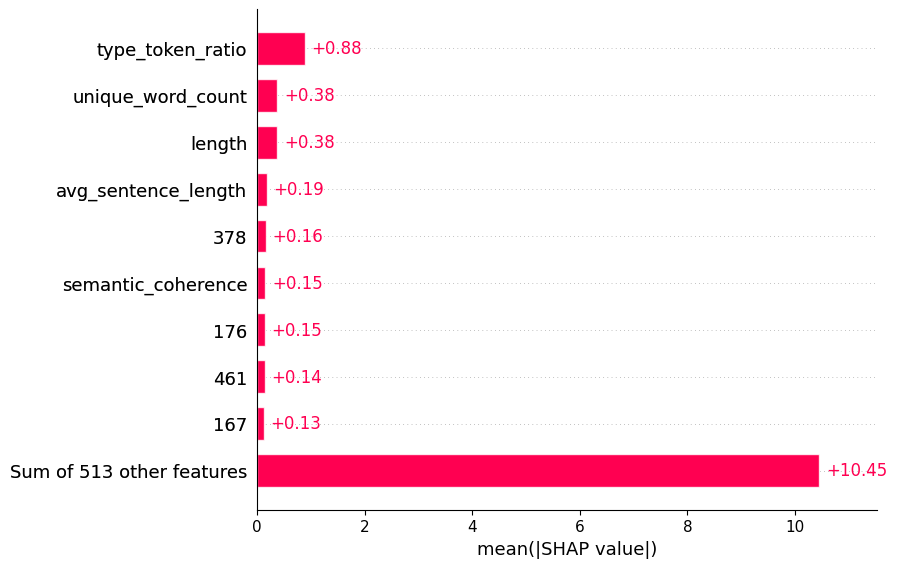

In [19]:
subset = X_train_creativity_scaled.sample(500, random_state=42)  # 500 rows only
shap_values = explainer(subset)
shap.plots.bar(shap_values, max_display=10)

Sample 53831 (Row 0) - Local SHAP Explanation


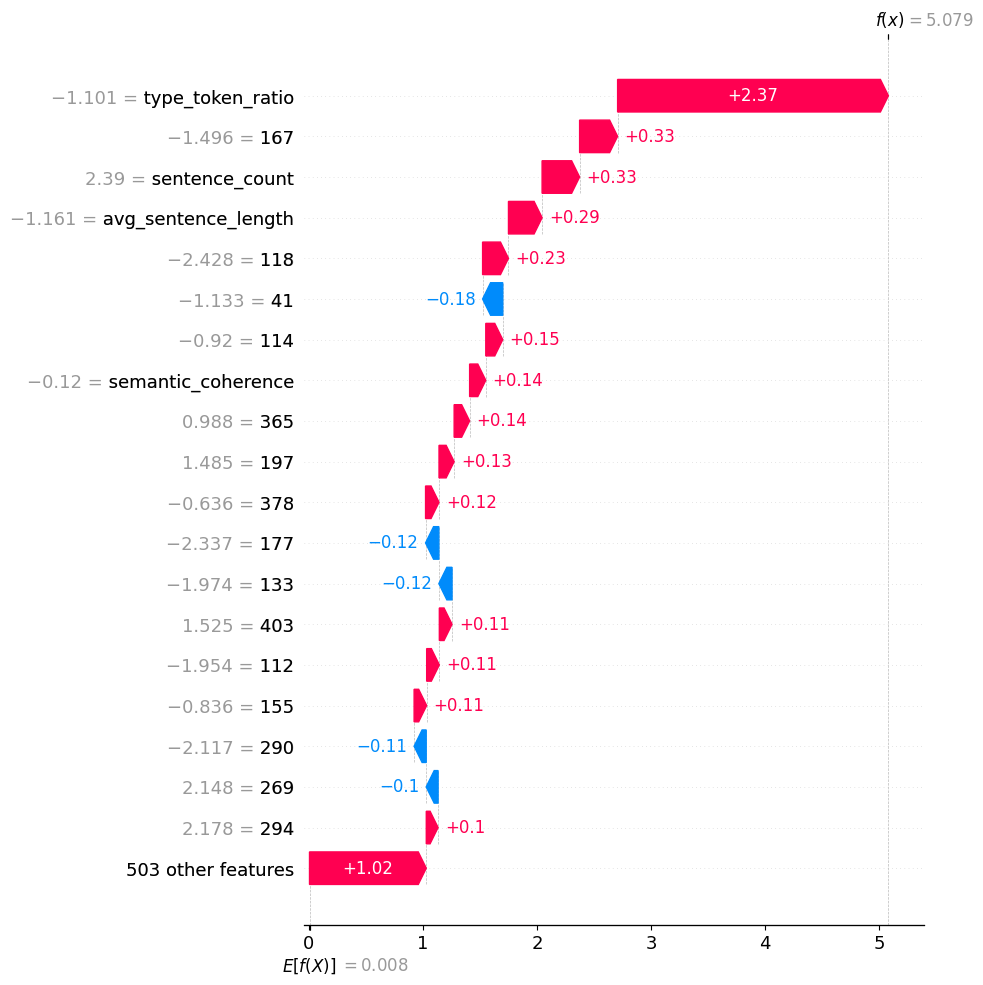

Sample 51018 (Row 1) - Local SHAP Explanation


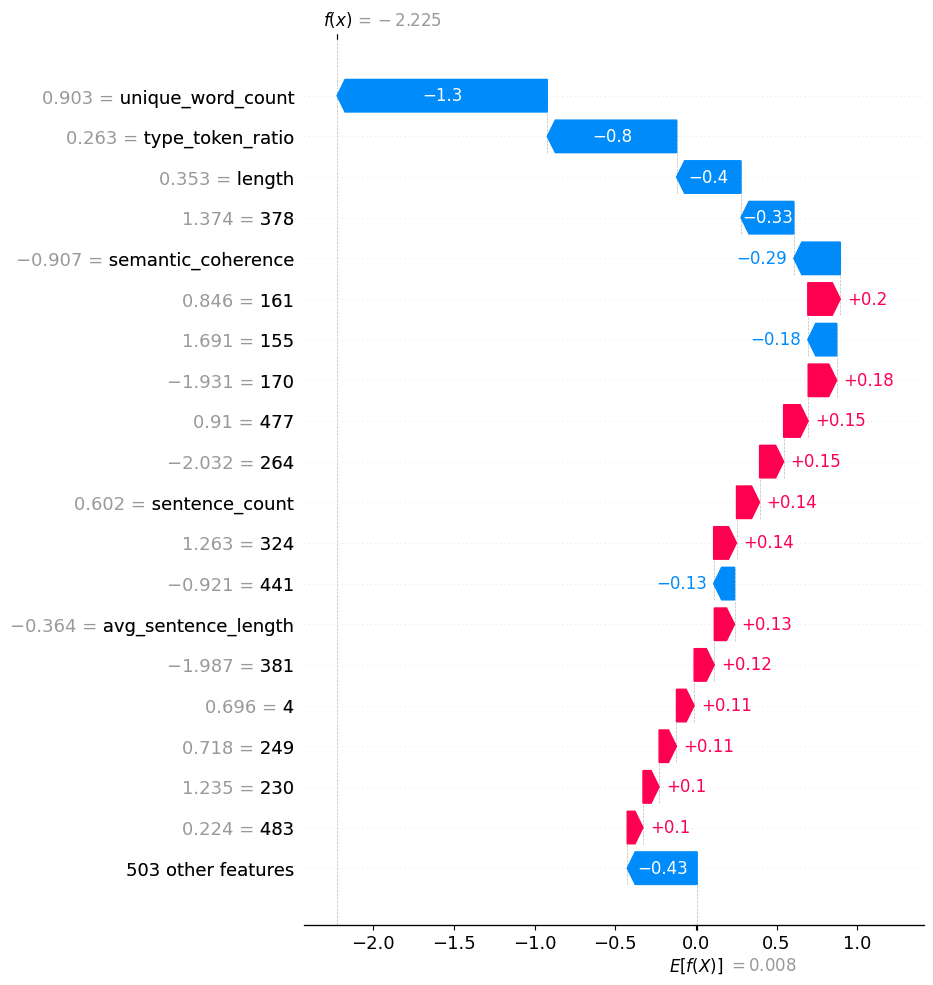

Sample 26411 (Row 2) - Local SHAP Explanation


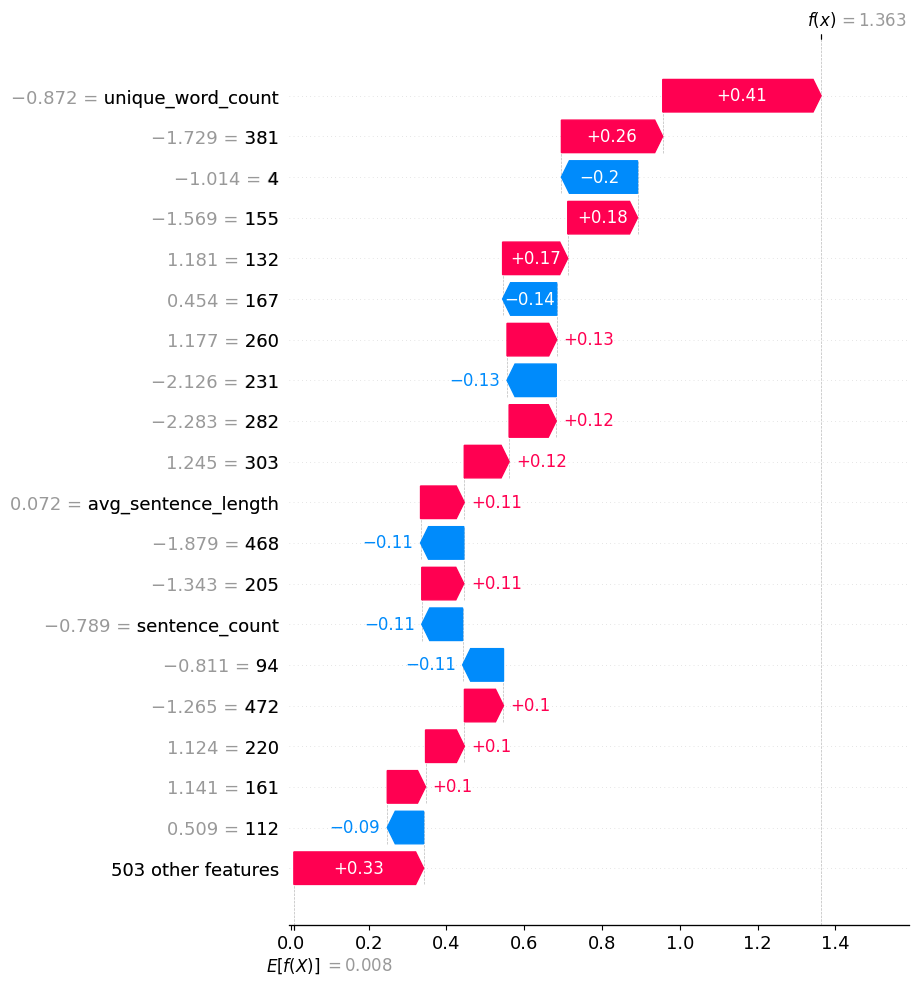

Sample 46666 (Row 3) - Local SHAP Explanation


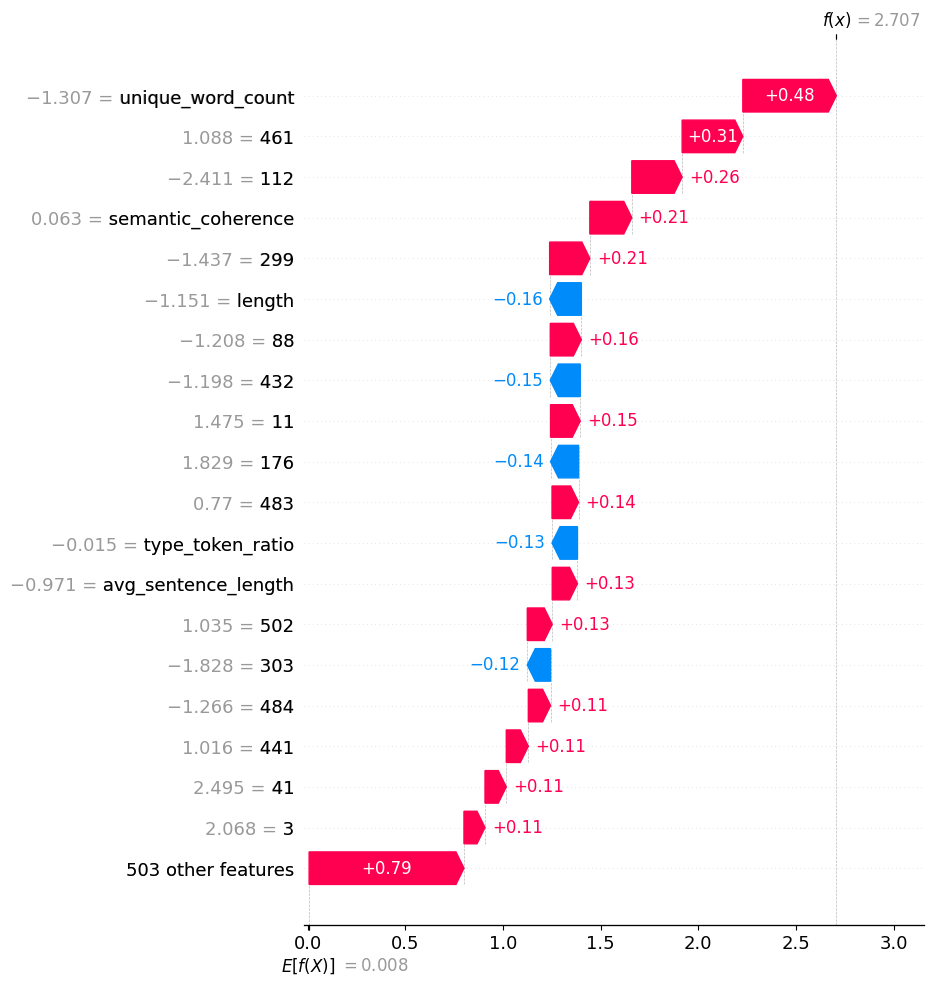

Sample 4780 (Row 4) - Local SHAP Explanation


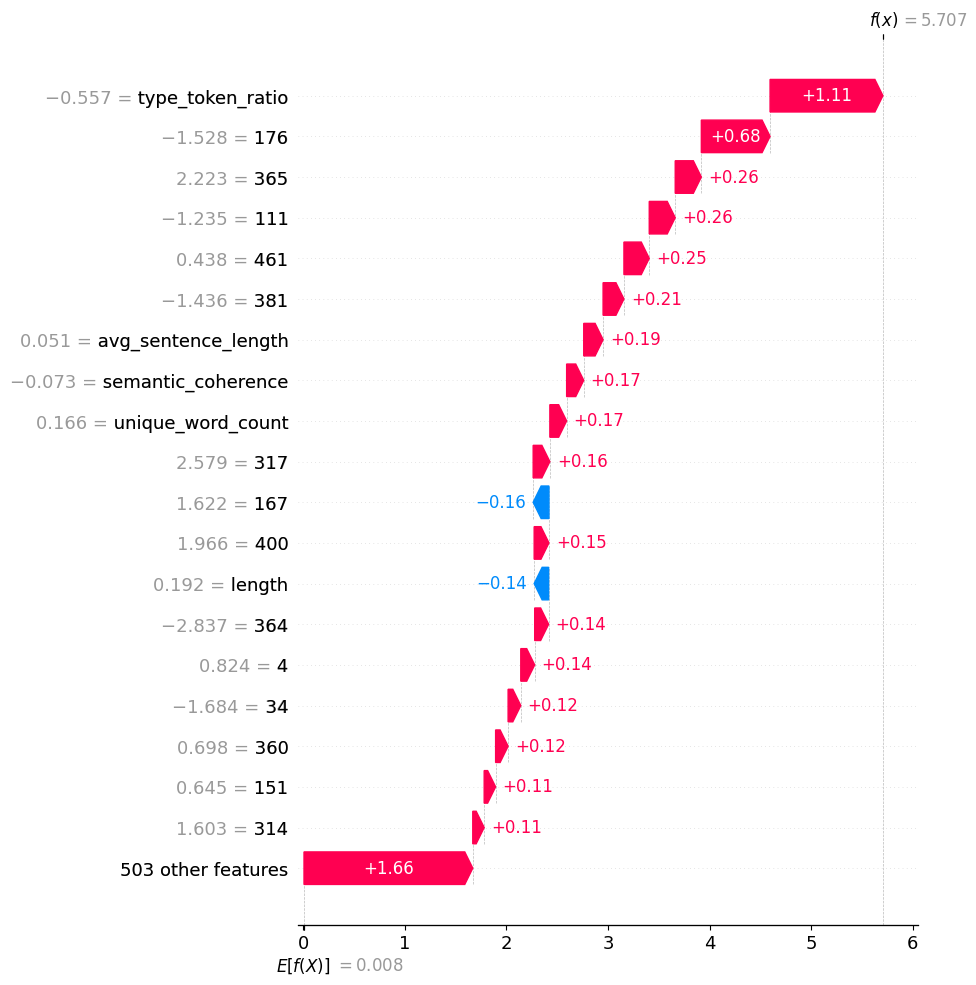

Sample 18962 (Row 5) - Local SHAP Explanation


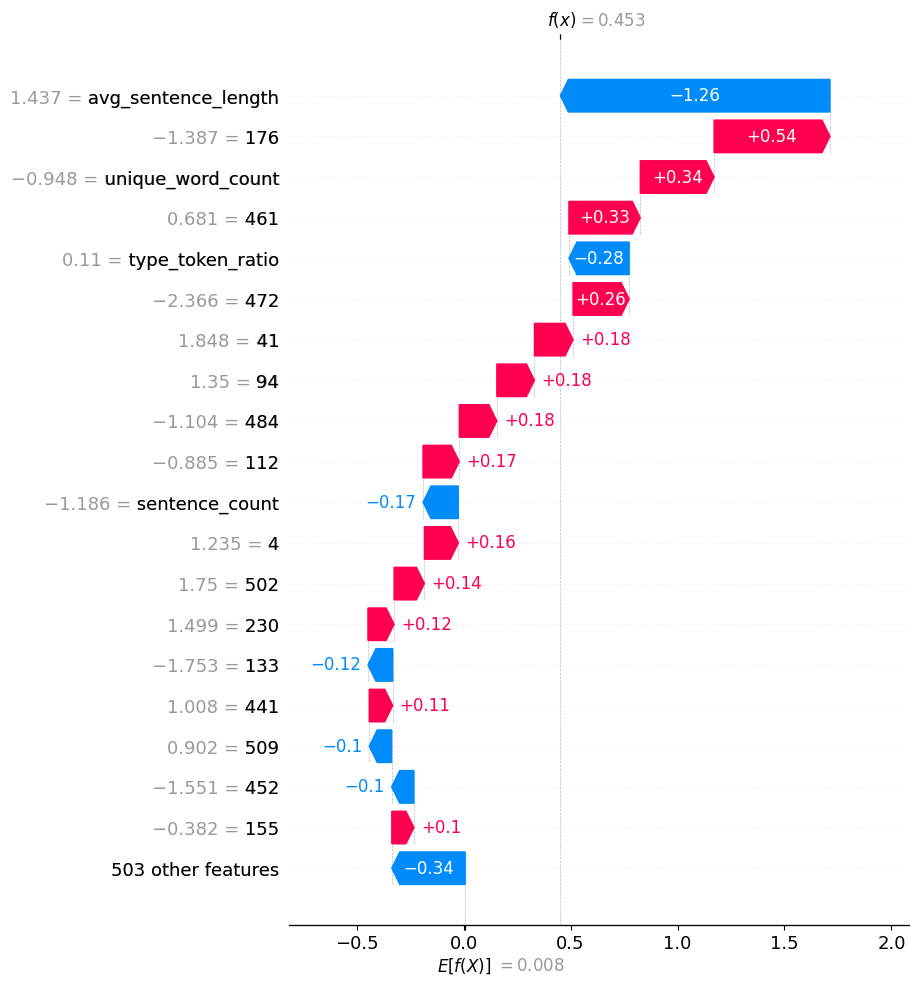

Sample 4053 (Row 6) - Local SHAP Explanation


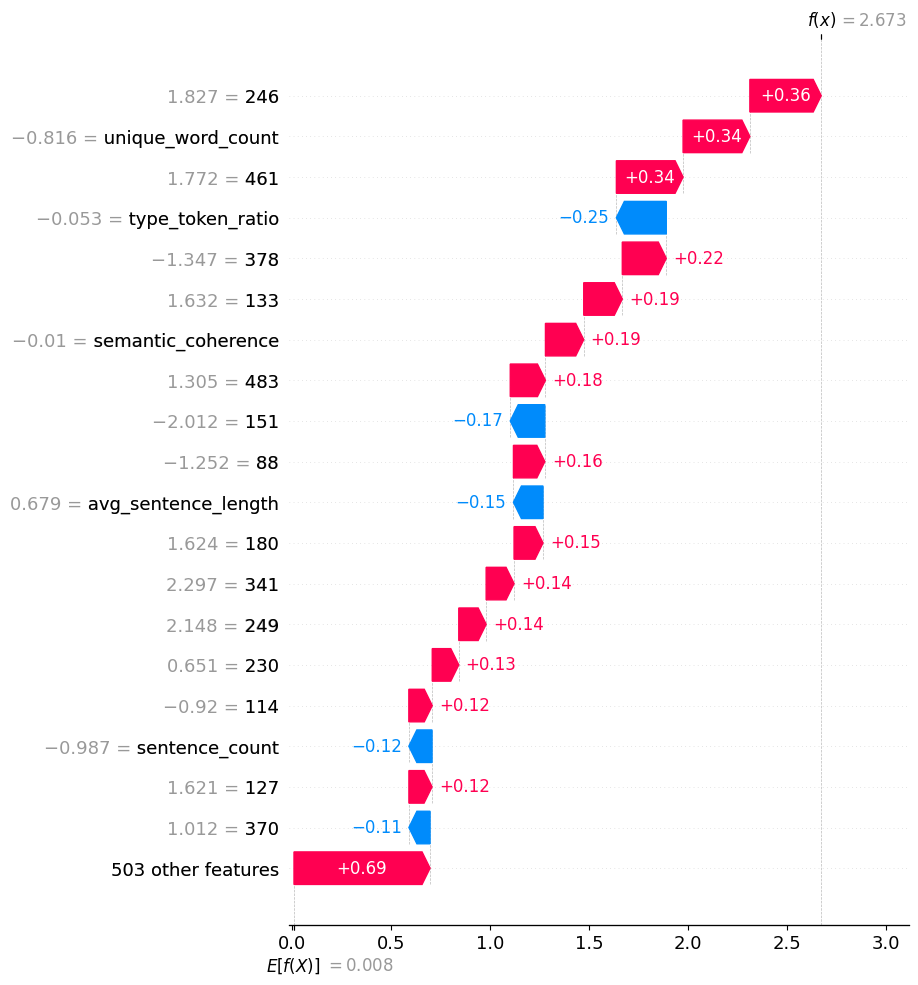

Sample 11209 (Row 7) - Local SHAP Explanation


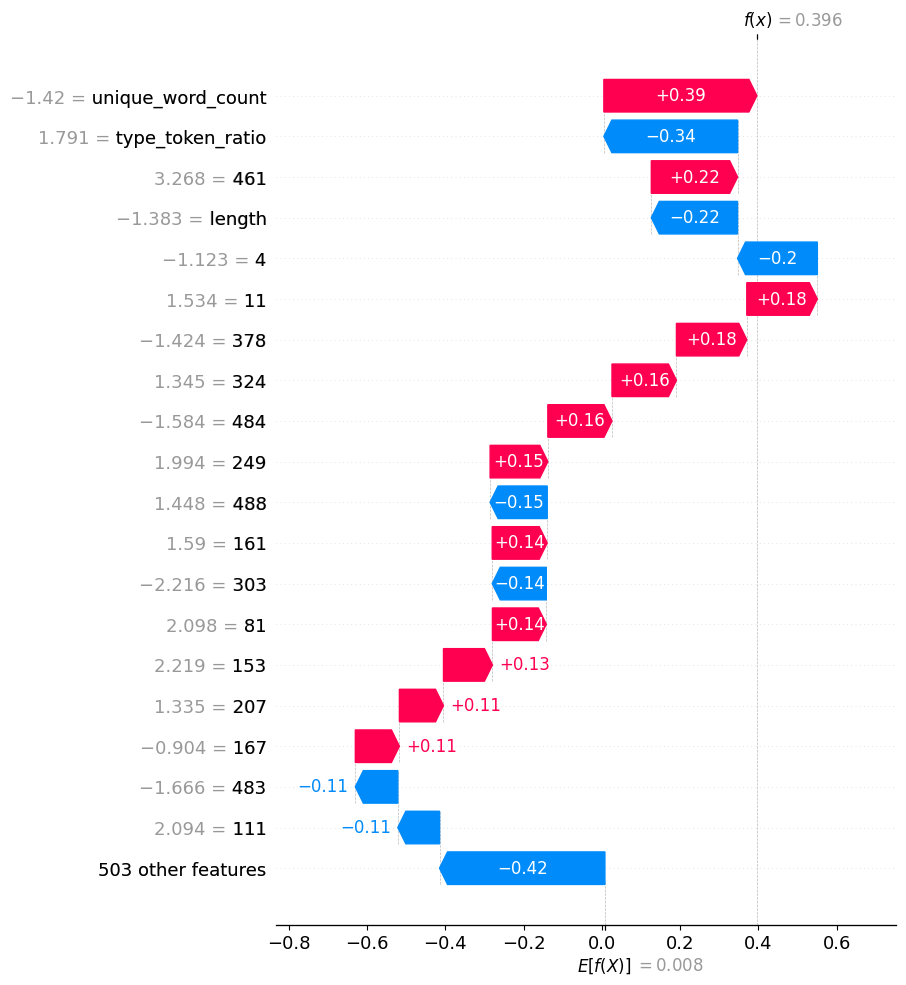

Sample 57424 (Row 8) - Local SHAP Explanation


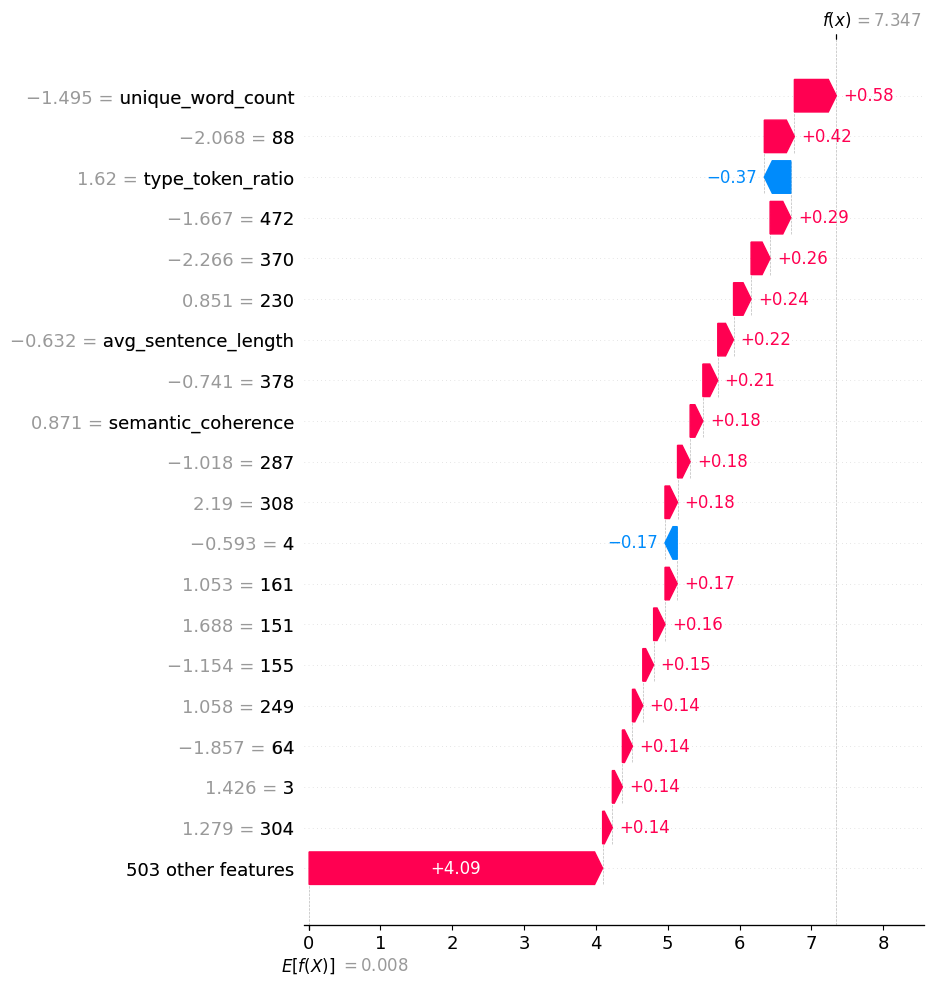

Sample 30919 (Row 9) - Local SHAP Explanation


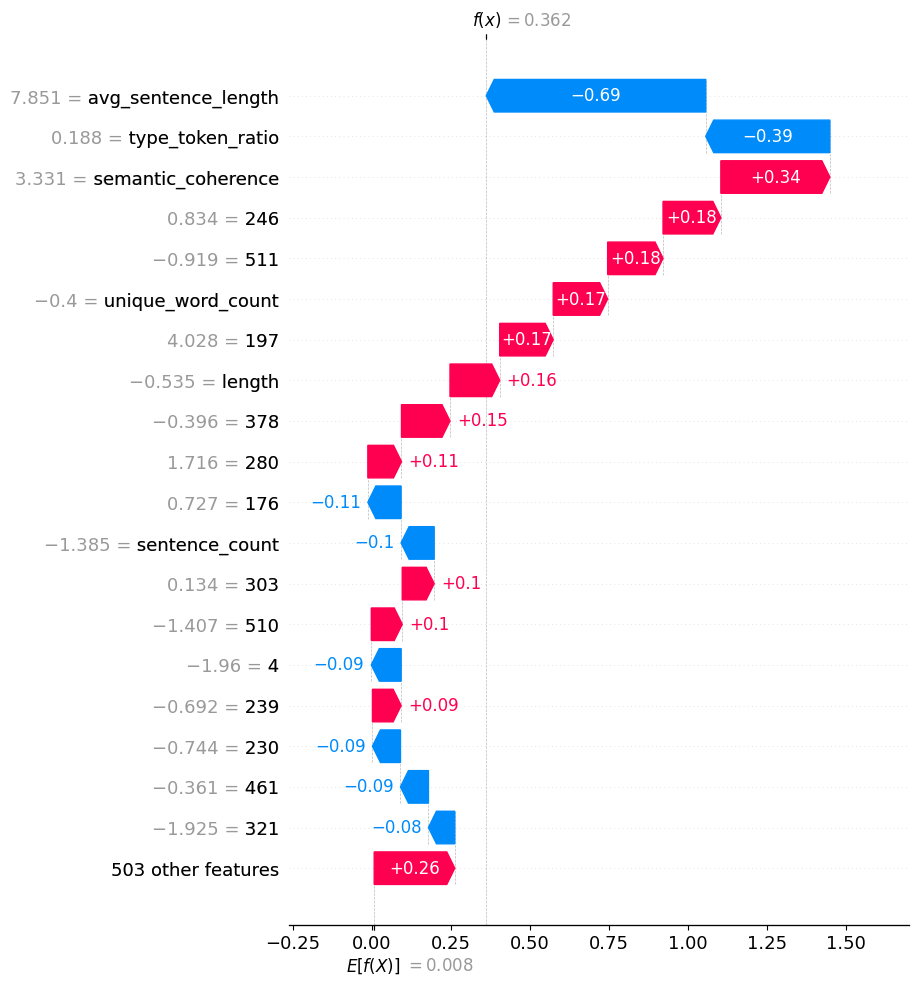

In [21]:

# ------------------------
# 2. Waterfall plots (local explanation)
# ------------------------
subset = X_test_creativity_scaled.sample(10, random_state=42)
shap_values_subset = explainer(subset)
for i, idx in enumerate(subset.index):
    print(f"Sample {idx} (Row {i}) - Local SHAP Explanation")
    shap.plots.waterfall(shap_values_subset[i], max_display=20)
    plt.show()

In [17]:
import shap

# Make sure your model is the one trained with creativity features
# model: XGBoost trained on X_train, y_train with creativity features
# X_train: training data features

# ===== 1. Create SHAP explainer =====
explainer = shap.TreeExplainer(model_creativity)
shap_values = explainer.shap_values(X_train_creativity_scaled)

# ===== 2. Summary plot (global feature importance) =====
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_train_creativity_scaled, plot_type="bar", max_display=20)
plt.title("SHAP Feature Importance - Creativity Model")
plt.show()

# ===== 3. Detailed summary plot (bee-swarm) =====
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_train_creativity_scaled, plot_type="dot", max_display=20)
plt.title("SHAP Summary Plot - Creativity Model")
plt.show()

# # ===== 4. Force plot for a single instance =====
# # Pick an instance to explain (example: first row of test set)
# idx = 0
# shap.initjs()  # enable interactive JS plots in notebooks
# force_plot = shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train_creativity.iloc[idx,:])
# force_plot

KeyboardInterrupt: 

In [ ]:
# ------------------------
# 3. Waterfall Plot (Local Explanation)
# ------------------------
# pick a representative sample, e.g. first test sample
sample_idx = 0
shap.plots.waterfall(shap_values[sample_idx], max_display=10)
plt.title("SHAP Waterfall Plot (Sample 0) - Creativity Model", fontsize=14)
plt.show()